## Import statements

In [1]:
library(BBmisc)
library(bnlearn)
library(penalized)
library(rbmn)


Attaching package: 'bnlearn'

The following object is masked from 'package:stats':

    sigma

Loading required package: survival
Welcome to penalized. For extended examples, see vignette("penalized").
Loading required package: MASS


## 1. Function to input datasets

In [4]:
read_data <- function(unitname, filename, normalize=TRUE){
    input <- read.delim(paste("C:/Users/abhig/OneDrive/Documents/#COURSES/#MTP/data/data", filename, "_", unitname,".txt", sep=""))
    input$X <- NULL
    if(unitname == "mixer" || unitname == "reactor"){
        colnames(input)[4] = "R5"
    }
    if(unitname==""){
        input <- cbind(input,R5=rep(input$F5))
    }
    if(normalize){
        return (BBmisc::normalize(input))
    }
    else{
        return (input)
    }
}

## 2a. Function to plot the graph (given model)

In [5]:
plot_graph <- function(dag){
    par(cex=0.07)
    options(repr.plot.width=3, repr.plot.height=3)
    hlight <- list(nodes = nodes(dag), arcs = arcs(dag), col = "black", textCol = "black", fill ='lightblue', lwd = 2)
    graphviz.plot(dag, highlight = hlight)    
}

## 2b. Function to plot a graph-comparison between two models

In [6]:
compare_graph <- function(dag1, dag2){
    message("True Positive   : BLACK arcs")
    message("False Positive  : BLUE arcs")
    message("False Negaitive : RED arcs")
    par(cex=0.08)
    options(repr.plot.width=3, repr.plot.height=3)
    hlight <- list(tp.col = "black", tp.lty = 1, tp.lwd =2, fp.col = "deepskyblue", fp.lty = 5, fp.lwd =2, fn.col = "red", fn.lty = 2, fn.lwd =2)
    graphviz.compare(dag1, dag2, diff="from-first", diff.args = hlight)
}

## 2c. Function to compare two models across various metrics

In [7]:
compare_models <- function(dag1, dag2, verbose=TRUE){
    res = compare(dag2, dag1, arcs = FALSE)
    TP = res$tp
    FP = res$fp
    FN = res$fn
    Recall = TP/ (TP+FN)
    Precision = TP/ (TP+FP)
    F1 = 2*TP/ (2*TP + FP + FN)
    if(verbose){
        print(paste("True Positive          = ", TP))
        print(paste("False Positive         = ", FP))
        print(paste("False Negative         = ", FN))
        print(paste("Recall (sensitivity)   = ", Recall))
        print(paste("Precision              = ", Precision))
        print(paste("F1 score               = ", F1))
    }
    return(F1)
}

## 3. Function to fit linear gaussian model

In [8]:
gaussian <- function(dag, data, verbose=FALSE){  
    print(modelstring(dag))
    est.para <- bn.fit(dag, data)
    if(verbose){
        print(est.para)
    }
    return(est.para)
}

## 4. Function to calculate score

In [9]:
graph_score <- function(dag, data, verbose=TRUE) {
    loglik <- bnlearn::score(dag, data, type = "loglik-g")
    aic <- bnlearn::score(dag, data, type = "aic-g")
    bic <- bnlearn::score(dag, data, type = "bic-g")
    bge <- bnlearn::score(dag, data, type = "bge")
    if(verbose){
        print(paste("The multivariate Gaussian log-likelihood score         = ", loglik))
        print(paste("The corresponding Akaike Information Criterion score   = ", aic))
        print(paste("The corresponding Bayesian Information Criterion score = ", bic))
        print(paste("A score equivalent Gaussian posterior density          = ", bge))
        cat("\n")
    }
    return(data.frame(loglik, aic, bic, bge))
}

## 5. Function to compare scores across 3 configurations and 4 datasets

In [10]:
compare_scores <- function(dag0, dag1, dag2, unitname){
    data_1a <- read_data(unitname, "1a")
    data_0 <- read_data(unitname, "0")
    data_3a <- read_data(unitname, "3a")
    data_3d <- read_data(unitname, "3d")
    
    score0 <- graph_score(dag0, data = data_1a, FALSE)
    score1 <- graph_score(dag1, data = data_1a, FALSE)
    score2 <- graph_score(dag2, data = data_1a, FALSE)
    score1a <- rbind(score0, score1, score2)

    score0 <- graph_score(dag0, data = data_0, FALSE)
    score1 <- graph_score(dag1, data = data_0, FALSE)
    score2 <- graph_score(dag2, data = data_0, FALSE)
    score0 <- rbind(score0, score1, score2)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score2 <- graph_score(dag2, data = data_3a, FALSE)
    score3a <- rbind(score0, score1, score2)
    
    score0 <- graph_score(dag0, data = data_3d, FALSE)
    score1 <- graph_score(dag1, data = data_3d, FALSE)
    score2 <- graph_score(dag2, data = data_3d, FALSE)
    score3d <- rbind(score0, score1, score2)
    
    return(cbind(score1a, score0, score3a, score3d))    
}

In [11]:
compare_scores_2 <- function(dag0, dag1, unitname){
    data_1a <- read_data(unitname, "1a")
    data_0 <- read_data(unitname, "0")
    data_3a <- read_data(unitname, "3a")
    data_3d <- read_data(unitname, "3d")
    
    score0 <- graph_score(dag0, data = data_1a, FALSE)
    score1 <- graph_score(dag1, data = data_1a, FALSE)
    score1a <- rbind(score0, score1 )

    score0 <- graph_score(dag0, data = data_0, FALSE)
    score1 <- graph_score(dag1, data = data_0, FALSE)
    score0 <- rbind(score0, score1)
    
    score0 <- graph_score(dag0, data = data_3a, FALSE)
    score1 <- graph_score(dag1, data = data_3a, FALSE)
    score3a <- rbind(score0, score1)
    
    score0 <- graph_score(dag0, data = data_3d, FALSE)
    score1 <- graph_score(dag1, data = data_3d, FALSE)
    score3d <- rbind(score0, score1)
    
    return(cbind(score1a, score0, score3a, score3d))    
}

## 6. Function to learn structure using hill climbing approach (score based)

In [12]:
learn_structure <- function(true_dag, unitname, filename, whitelist = NULL, blacklist = NULL, plot_graphs = TRUE, compare_networks = FALSE, print_dag = TRUE){ 
    
    dataset <- read_data(unitname, filename)
    
    stru1 <- bnlearn::hc(dataset, score = "aic-g", start = random.graph(names(dataset)), whitelist = whitelist, blacklist = blacklist)  
    message(paste("score = AIC, dataset =" , filename))
    aic = compare_models(true_dag, stru1, TRUE)
    
    stru2 <- bnlearn::hc(dataset, score = "bic-g", start = random.graph(names(dataset)), whitelist = whitelist, blacklist = blacklist)        
    message(paste("score = BIC, dataset =" , filename))
    bic = compare_models(true_dag, stru2, TRUE)
    
    stru3 <- bnlearn::hc(dataset, score = "bge", start = random.graph(names(dataset)), whitelist = whitelist, blacklist = blacklist)
    message(paste("score = BGE, dataset =" , filename))
    bge = compare_models(true_dag, stru3, TRUE)
    
    stru4 <- bnlearn::hc(dataset, score = "loglik-g", start = random.graph(names(dataset)), whitelist = whitelist, blacklist = blacklist)
    message(paste("score = LOGLIKE, dataset =" , filename))
    loglike = compare_models(true_dag, stru4, TRUE)
    
    if(plot_graphs){
        plot_graph(stru1)
        plot_graph(stru2)
        plot_graph(stru3)
        plot_graph(stru4)
    }
    
    if(compare_networks){
        compare_graph(true_dag, stru1)
        compare_graph(true_dag, stru2)
        compare_graph(true_dag, stru3)
        compare_graph(true_dag, stru4)
    }
    
    if(print_dag){
        message(paste("DAG [AIC]: " , stru1))
        message(paste("DAG [BIC]: " , stru2))
        message(paste("DAG [BGe]: " , stru3))
        message(paste("DAG [Loglike]: " , stru4))
    }
    
    F1_measure = list("aic" = aic, "bic" = bic, "bge" = bge, "loglike" = loglike)
    return(F1_measure)
    
}    

<hr>

<hr>

<span style="color:red"><font size="6"><b>7a. MIXER...</b></font></span>

### [Mixer] 3 configurations: 1 true and 2 randoms

In [13]:
mixer <- model2network("[F1][F2][F3][R5][F6|F1:F2:F3:R5]")
mixer_rnd1 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6"))
mixer_rnd2 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6"))

### [Mixer] Plotting graphs of all three configurations

Loading required namespace: Rgraphviz


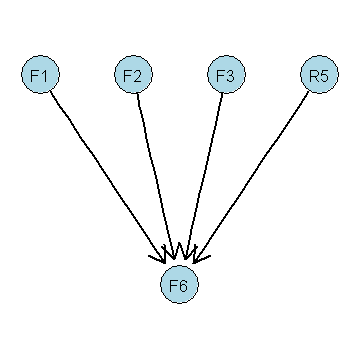

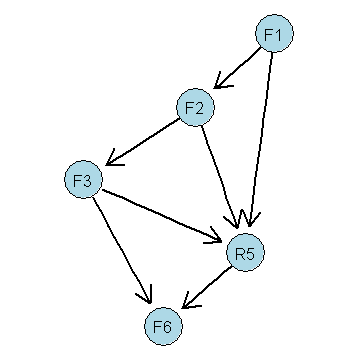

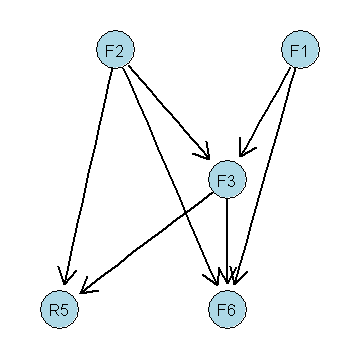

In [14]:
plot_graph(mixer)
plot_graph(mixer_rnd1)
plot_graph(mixer_rnd2)

### [Mixer] Fitting each of the three into linear gaussian model.

In [16]:
gaussian_mixer <- gaussian(mixer, read_data("mixer", "1a"))
gaussian_mixer_rnd1 <- gaussian(mixer_rnd1, read_data("mixer", "1a"))
gaussian_mixer_rnd2 <- gaussian(mixer_rnd2, read_data("mixer", "1a"))

[1] "[F1][F2][F3][R5][F6|F1:F2:F3:R5]"
[1] "[F1][F2|F1][F3|F2][R5|F1:F2:F3][F6|F3:R5]"
[1] "[F1][F2][F3|F1:F2][R5|F2:F3][F6|F1:F2:F3]"


### [Mixer] Comparing scores across 3 configurations and 4 datasets.

In [17]:
compare_scores(mixer, mixer_rnd1, mixer_rnd2, "mixer")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-7095.069,-7104.069,-7126.158,-7130.037,-7097.619,-7106.619,-7128.708,-7132.585,-7095.457,-7104.457,-7126.546,-7130.425,-7097.619,-7106.619,-7128.708,-7132.585
-7085.303,-7097.303,-7126.755,-7128.023,-7097.619,-7106.619,-7128.708,-7132.585,-7073.548,-7085.548,-7115.000,-7116.312,-7095.842,-7107.842,-7137.295,-7138.527
-7087.490,-7099.490,-7128.943,-7130.243,-7097.619,-7106.619,-7128.708,-7132.585,-7079.321,-7091.321,-7120.773,-7122.099,-7085.370,-7097.370,-7126.823,-7128.131


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Mixer] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  2"
[1] "False Positive         =  2"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.5"
[1] "F1 score               =  0.5"


score = BIC, dataset = 1a


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 1a


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  4"
[1] "False Positive         =  0"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.4"
[1] "Precision              =  1"
[1] "F1 score               =  0.571428571428571"


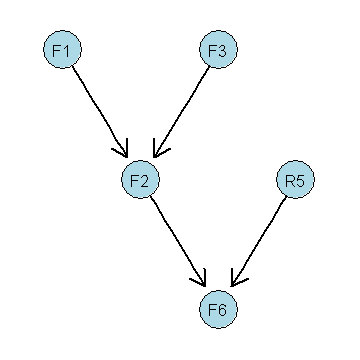

DAG [AIC]:  [F1][F3][R5][F2|F1:F3][F6|F2:R5]
DAG [BIC]:  [F1][F2][R5][F6][F3|F2]
DAG [BGe]:  [F1][F2][R5][F6][F3|F2]
DAG [Loglike]:  [F1][F2|F1][R5|F1:F2][F3|F1:F2:R5][F6|F1:F2:F3:R5]


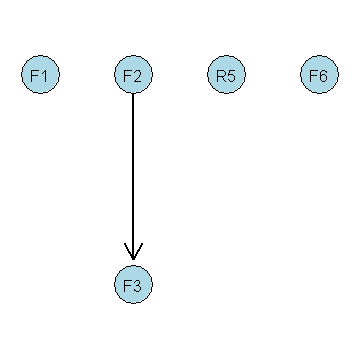

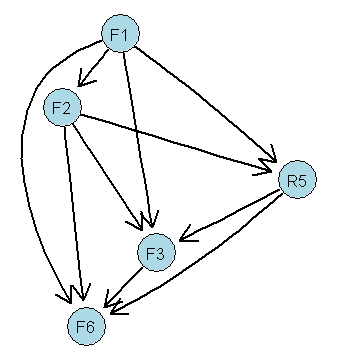

In [18]:
Mixer = learn_structure(mixer, "mixer", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BIC, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  1"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.75"
[1] "F1 score               =  0.461538461538462"


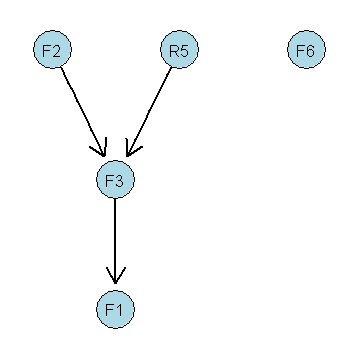

DAG [AIC]:  [F2][R5][F6][F3|F2:R5][F1|F3]
DAG [BIC]:  [F1][F2][R5][F6][F3|F2]
DAG [BGe]:  [F1][F2][R5][F6][F3|F2]
DAG [Loglike]:  [F1][F2|F1][F3|F1:F2][F6|F1:F2:F3][R5|F2:F3:F6]


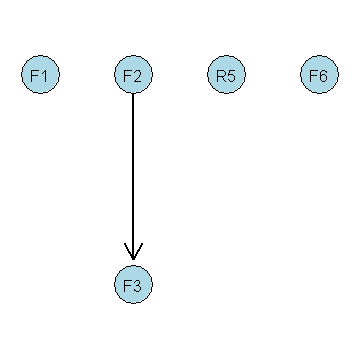

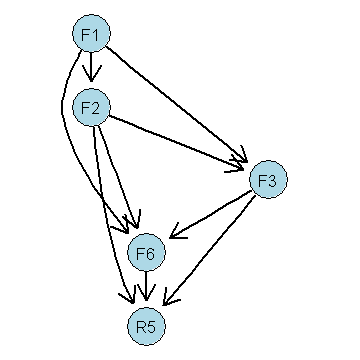

In [19]:
mixer_0 = learn_structure(mixer, "mixer", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BIC, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  3"
[1] "False Positive         =  1"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.3"
[1] "Precision              =  0.75"
[1] "F1 score               =  0.428571428571429"


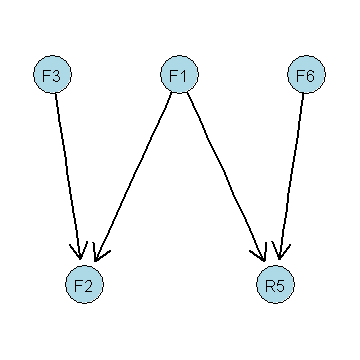

DAG [AIC]:  [F1][F3][F6][F2|F1:F3][R5|F1:F6]
DAG [BIC]:  [F1][F3][R5][F6][F2|F1:F3]
DAG [BGe]:  [F1][F3][R5][F6][F2|F1:F3]
DAG [Loglike]:  [F1][F2|F1][R5|F1:F2][F6|F1:F2:R5][F3|F1:F2:R5:F6]


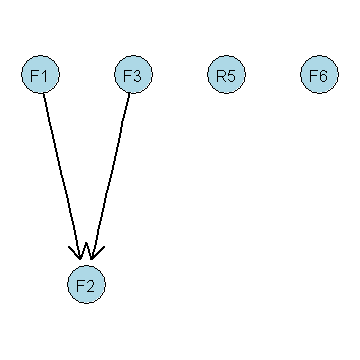

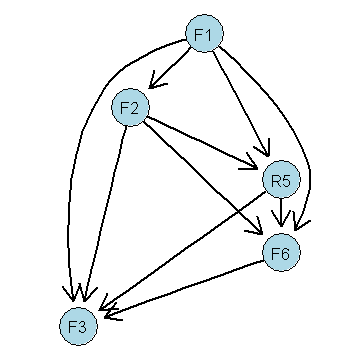

In [20]:
mixer_3a = learn_structure(mixer, "mixer", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BIC, dataset = 3d


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 3d


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  3"
[1] "False Positive         =  1"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.3"
[1] "Precision              =  0.75"
[1] "F1 score               =  0.428571428571429"


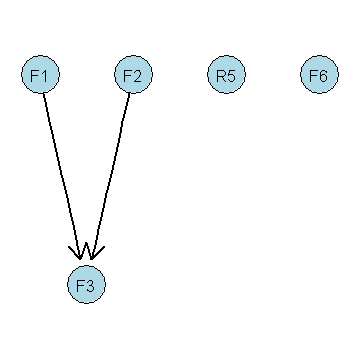

DAG [AIC]:  [F1][F2][R5][F6][F3|F1:F2]
DAG [BIC]:  [F1][F2][R5][F6][F3|F1]
DAG [BGe]:  [F1][F2][R5][F6][F3|F1]
DAG [Loglike]:  [F1][F2|F1][F3|F1:F2][F6|F1:F2:F3][R5|F1:F2:F3:F6]


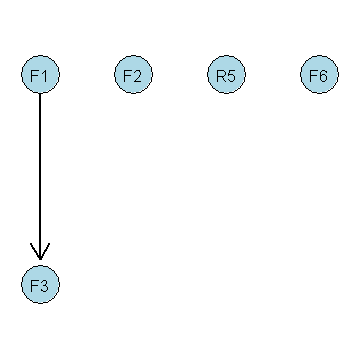

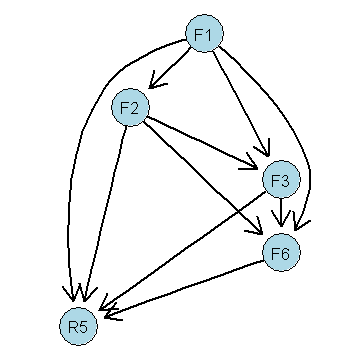

In [21]:
mixer_3d = learn_structure(mixer, "mixer", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on MIXER structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BIC, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 0


[1] "True Positive          =  0"
[1] "False Positive         =  4"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."DAG [AIC]:  [F1][F2][F3][R5][F6]
DAG [BIC]:  [F1][F2][F3][R5][F6]
DAG [BGe]:  [F1][F2][F3][R5][F6]
DAG [Loglike]:  [F1][F2][F3][R5][F6|F1:F2:F3:R5]


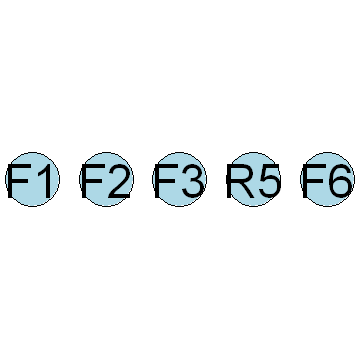

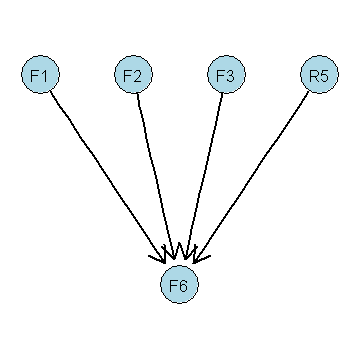

In [22]:
from2  = c("F1", "F1", "F1", "F2", "F2", "F2", "F3", "F3", "F3", "R5", "R5", "R5", "F6", "F6", "F6", "F6")
to2 = c("F2", "F3", "R5", "F1", "F3", "R5", "F2", "F1", "R5", "F3", "F2", "F1", "R5", "F3", "F2", "F1")
black_mixer = data.frame("from"=from2, "to"=to2)
Mixer_mod = learn_structure(mixer, "mixer", "0", whitelist = NULL, blacklist = black_mixer)

<span style="color:brown"><font size="4"><b>[Mixer] Comparing OBTAINED structure with the GIVEN structure</b></font></span>

[1] "True Positive          =  4"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


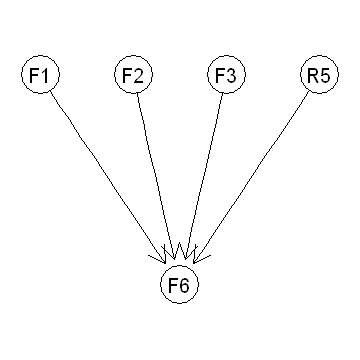

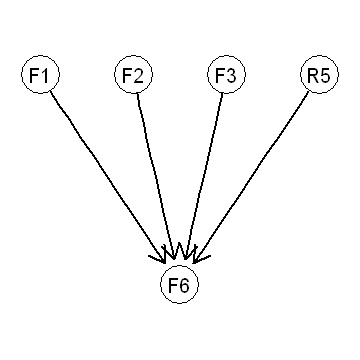

In [15]:
mixer1 <- model2network("[F1][F2][F3][R5][F6|F1:F2:F3:R5]")
garbage =compare_models(mixer, mixer1)
compare_graph(mixer1, mixer)

<span style="color:green"><font size="5"><b>[Mixer] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [23]:
rbind(Mixer_mod, Mixer, mixer_0, mixer_3a, mixer_3d)

,aic,bic,bge,loglike
Mixer_mod,0,0,0,1
Mixer,0.5,0,0,0.5714286
mixer_0,0,0,0,0.4615385
mixer_3a,0,0,0,0.4285714
mixer_3d,0,0,0,0.4285714


<hr>

<hr>

<span style="color:red"><font size="6"><b>7b. REACTOR...</b></font></span>

### [Reactor] 3 configurations: 1 true and 2 randoms

In [24]:
reactor <- model2network("[F1][F2][F3][R5][T21|F1:F6:R5:F3:T9][T9|R5:F6][P7|F1:R5:F6:L8:T9:T21][L8|F1:F2:R5:F6:T21][F6|F1:F2:F3:R5]")
reactor_rnd1 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7"))
reactor_rnd2 <- random.graph(nodes = c("F1", "F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7"))

### [Reactor] Plotting graphs of all three configurations

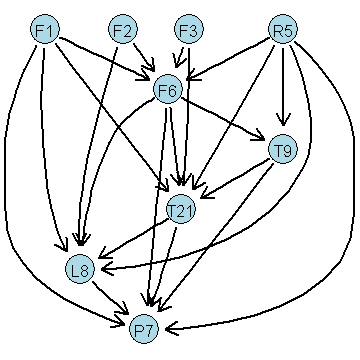

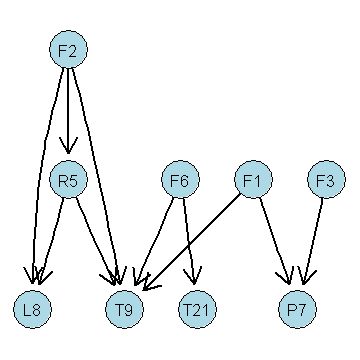

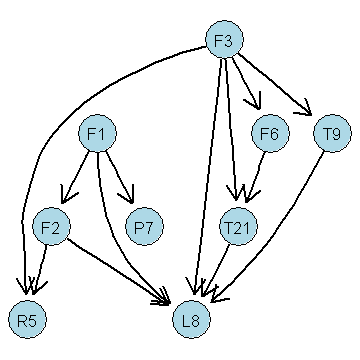

In [25]:
plot_graph(reactor)
plot_graph(reactor_rnd1)
plot_graph(reactor_rnd2)

### [Reactor] Fitting each of the three into linear gaussian model.

In [27]:
gaussian_reactor <- gaussian(reactor, read_data("reactor", "1a"))
gaussian_reactor_rnd1 <- gaussian(reactor_rnd1, read_data("reactor", "1a"))
gaussian_reactor_rnd2 <- gaussian(reactor_rnd2, read_data("reactor", "1a"))

[1] "[F1][F2][F3][R5][F6|F1:F2:F3:R5][T9|F6:R5][T21|F1:F3:F6:R5:T9][L8|F1:F2:F6:R5:T21][P7|F1:F6:L8:R5:T21:T9]"
[1] "[F1][F2][F3][F6][R5|F2][T21|F6][P7|F1:F3][T9|F1:F2:R5:F6][L8|F2:R5]"
[1] "[F1][F3][F2|F1][F6|F3][T9|F3][P7|F1][R5|F2:F3][T21|F3:F6][L8|F1:F2:F3:T21:T9]"


### [Reactor] Comparing scores across 3 configurations and 4 datasets.

In [28]:
compare_scores(reactor, reactor_rnd1, reactor_rnd2, "reactor")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-12701.86,-12732.86,-12808.95,-12804.61,-12702.25,-12733.25,-12809.34,-12805,-12675.14,-12706.14,-12782.23,-12777.92,-12702.25,-12733.25,-12809.34,-12805.00
-12752.53,-12771.53,-12818.16,-12822.69,-12702.25,-12733.25,-12809.34,-12805,-12754.02,-12773.02,-12819.66,-12824.17,-12765.86,-12784.86,-12831.49,-12835.96
-12722.61,-12744.61,-12798.61,-12800.84,-12702.25,-12733.25,-12809.34,-12805,-12711.31,-12733.31,-12787.31,-12789.57,-12756.05,-12778.05,-12832.05,-12834.16


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Reactor] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  6"
[1] "False Positive         =  16"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.461538461538462"
[1] "Precision              =  0.272727272727273"
[1] "F1 score               =  0.342857142857143"


score = BIC, dataset = 1a


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.375"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.2"


score = BGE, dataset = 1a


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.375"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.2"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  14"
[1] "False Positive         =  8"
[1] "False Negative         =  20"
[1] "Recall (sensitivity)   =  0.411764705882353"
[1] "Precision              =  0.636363636363636"
[1] "F1 score               =  0.5"


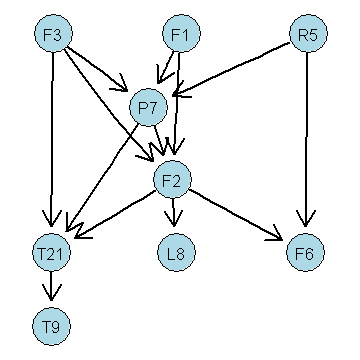

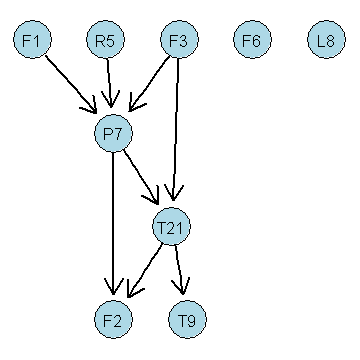

DAG [AIC]:  [F1][F3][R5][P7|F1:F3:R5][F2|F1:F3:P7][F6|F2:R5][L8|F2][T21|F2:F3:P7][T9|T21]
DAG [BIC]:  [F1][F3][R5][F6][L8][P7|F1:F3:R5][T21|F3:P7][F2|P7:T21][T9|T21]
DAG [BGe]:  [F1][F2][R5][F6][L8][F3|F2][P7|F1:F3:R5][T21|F2:F3:P7][T9|T21]
DAG [Loglike]:  [F1][F2|F1][F3|F1:F2][F6|F1:F2:F3][R5|F1:F2:F3:F6][P7|F1:F2:F3:R5:F6][L8|F1:F2:F3:R5:P7][T21|F1:F2:F3:R5:P7:L8][T9|F1:F2:F3:R5:F6:P7:L8:T21]


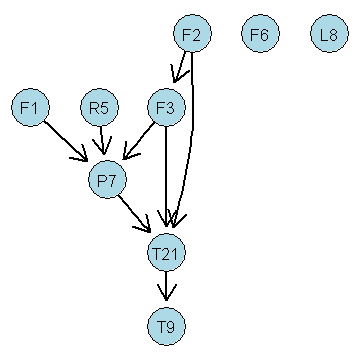

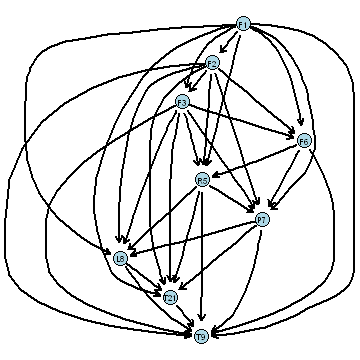

In [29]:
Reactor = learn_structure(reactor, "reactor", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  5"
[1] "False Positive         =  17"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.384615384615385"
[1] "Precision              =  0.227272727272727"
[1] "F1 score               =  0.285714285714286"


score = BIC, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.428571428571429"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.206896551724138"


score = BGE, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.428571428571429"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.206896551724138"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  11"
[1] "False Positive         =  11"
[1] "False Negative         =  24"
[1] "Recall (sensitivity)   =  0.314285714285714"
[1] "Precision              =  0.5"
[1] "F1 score               =  0.385964912280702"


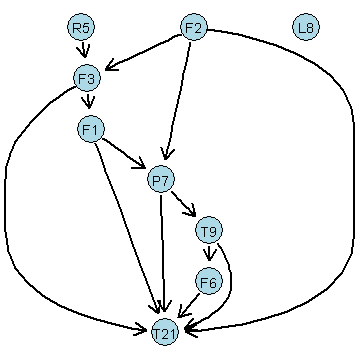

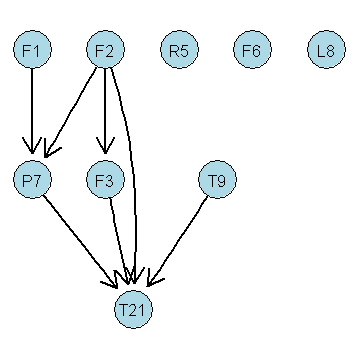

DAG [AIC]:  [F2][R5][L8][F3|F2:R5][F1|F3][P7|F1:F2][T9|P7][F6|T9][T21|F1:F2:F3:F6:P7:T9]
DAG [BIC]:  [F1][F2][R5][F6][L8][T9][F3|F2][P7|F1:F2][T21|F2:F3:P7:T9]
DAG [BGe]:  [F1][F2][R5][F6][L8][T9][F3|F2][P7|F1:F2][T21|F2:F3:P7:T9]
DAG [Loglike]:  [F1][F2|F1][P7|F1:F2][T9|F1:F2:P7][F6|F1:F2:P7:T9][T21|F1:F2:F6:P7:T9][R5|F2:F6:P7:T9:T21][F3|F1:F2:R5:F6:P7:T9:T21][L8|F1:F2:F3:R5:F6:P7:T9:T21]


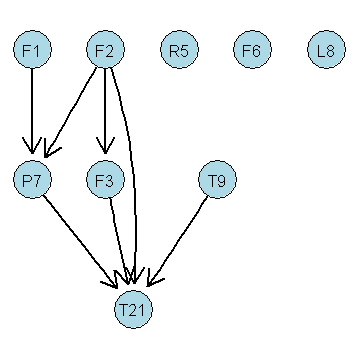

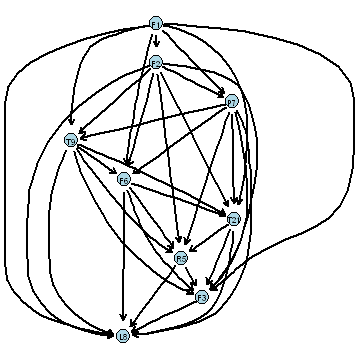

In [30]:
reactor_0 = learn_structure(reactor, "reactor", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  6"
[1] "False Positive         =  16"
[1] "False Negative         =  9"
[1] "Recall (sensitivity)   =  0.4"
[1] "Precision              =  0.272727272727273"
[1] "F1 score               =  0.324324324324324"


score = BIC, dataset = 3a


[1] "True Positive          =  1"
[1] "False Positive         =  21"
[1] "False Negative         =  9"
[1] "Recall (sensitivity)   =  0.1"
[1] "Precision              =  0.0454545454545455"
[1] "F1 score               =  0.0625"


score = BGE, dataset = 3a


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.193548387096774"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  10"
[1] "False Positive         =  12"
[1] "False Negative         =  25"
[1] "Recall (sensitivity)   =  0.285714285714286"
[1] "Precision              =  0.454545454545455"
[1] "F1 score               =  0.350877192982456"


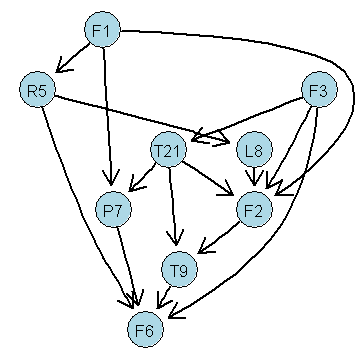

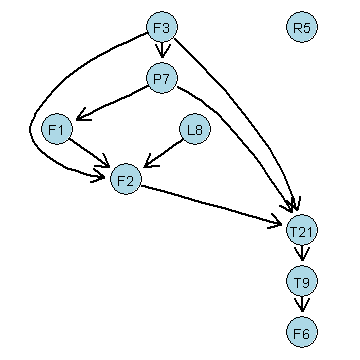

DAG [AIC]:  [F1][F3][R5|F1][T21|F3][P7|F1:T21][L8|R5][F2|F1:F3:L8:T21][T9|F2:T21][F6|F3:R5:P7:T9]
DAG [BIC]:  [F3][R5][L8][P7|F3][F1|P7][F2|F1:F3:L8][T21|F2:F3:P7][T9|T21][F6|T9]
DAG [BGe]:  [F1][F3][R5][L8][T21|F3][F2|F1:F3:L8:T21][P7|F1:T21][T9|T21][F6|T9]
DAG [Loglike]:  [F1][F3|F1][T21|F1:F3][P7|F1:F3:T21][L8|F1:F3:P7:T21][F2|F1:F3:P7:L8:T21][F6|F1:F2:F3:P7:L8:T21][T9|F1:F2:F3:F6:P7:L8:T21][R5|F1:F2:F3:F6:L8:T9:T21]


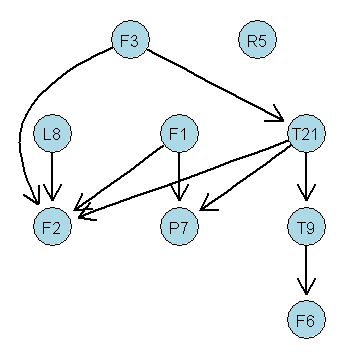

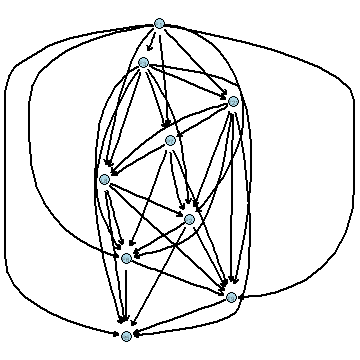

In [31]:
reactor_3a = learn_structure(reactor, "reactor", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  5"
[1] "False Positive         =  17"
[1] "False Negative         =  9"
[1] "Recall (sensitivity)   =  0.357142857142857"
[1] "Precision              =  0.227272727272727"
[1] "F1 score               =  0.277777777777778"


score = BIC, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  21"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.0454545454545455"
[1] "F1 score               =  0.0740740740740741"


score = BGE, dataset = 3d


[1] "True Positive          =  2"
[1] "False Positive         =  20"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.0909090909090909"
[1] "F1 score               =  0.142857142857143"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  11"
[1] "False Positive         =  11"
[1] "False Negative         =  23"
[1] "Recall (sensitivity)   =  0.323529411764706"
[1] "Precision              =  0.5"
[1] "F1 score               =  0.392857142857143"


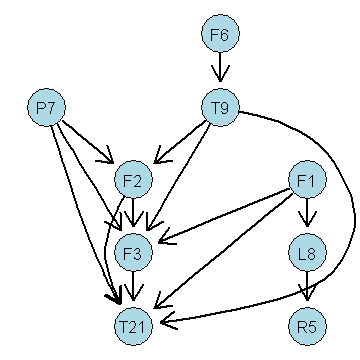

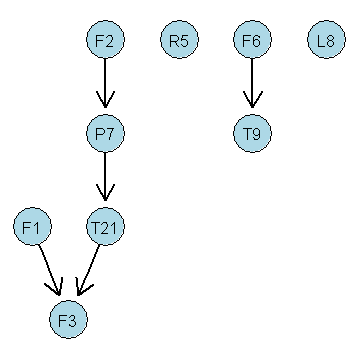

DAG [AIC]:  [F1][F6][P7][L8|F1][T9|F6][F2|P7:T9][R5|L8][F3|F1:F2:P7:T9][T21|F1:F2:F3:P7:T9]
DAG [BIC]:  [F1][F2][R5][F6][L8][P7|F2][T9|F6][T21|P7][F3|F1:T21]
DAG [BGe]:  [F1][F2][R5][F6][L8][P7|F2][T9|F6][T21|P7:T9][F3|F1:T21]
DAG [Loglike]:  [F1][F3|F1][T21|F1:F3][F2|F1:F3:T21][P7|F2:F3:T21][T9|F1:F2:F3:P7:T21][F6|F1:F2:F3:P7:T9:T21][R5|F1:F2:F3:F6:P7:T21][L8|F1:F2:F3:R5:F6:P7:T9:T21]


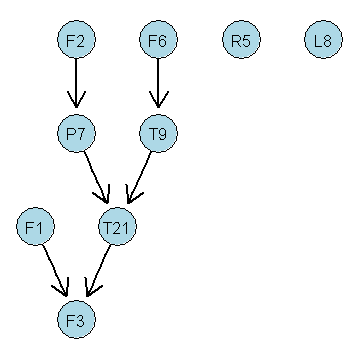

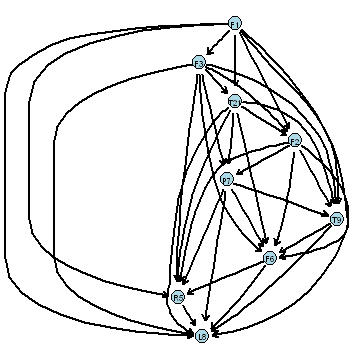

In [32]:
reactor_3d = learn_structure(reactor, "reactor", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on REACTOR structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  6"
[1] "False Positive         =  16"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.6"
[1] "Precision              =  0.272727272727273"
[1] "F1 score               =  0.375"


score = BIC, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.214285714285714"


score = BGE, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  19"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.136363636363636"
[1] "F1 score               =  0.214285714285714"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  18"
[1] "False Positive         =  4"
[1] "False Negative         =  12"
[1] "Recall (sensitivity)   =  0.6"
[1] "Precision              =  0.818181818181818"
[1] "F1 score               =  0.692307692307692"


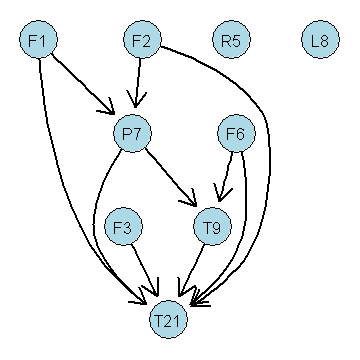

DAG [AIC]:  [F1][F2][F3][R5][F6][L8][P7|F1:F2][T9|F6:P7][T21|F1:F2:F3:F6:P7:T9]
DAG [BIC]:  [F1][F2][F3][R5][F6][L8][T9][P7|F1:F2][T21|F2:F3:P7:T9]
DAG [BGe]:  [F1][F2][F3][R5][F6][L8][T9][P7|F1:F2][T21|F2:F3:P7:T9]
DAG [Loglike]:  [F1][F2][F3][R5][F6|F1:F2:F3:R5][P7|F1:F2:F3:R5:F6][T9|F1:F2:F3:R5:F6:P7][L8|F1:F2:F3:R5:F6:P7:T9][T21|F1:F2:F3:R5:F6:P7:L8:T9]


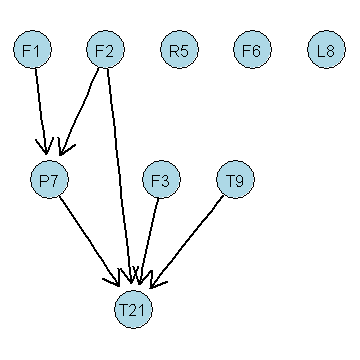

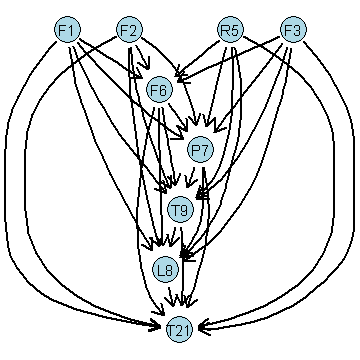

In [239]:
from2  = c("F1", "F1", "F1", "F2", "F2", "F2", "F3", "F3", "F3", "R5", "R5", "R5", "F6", "F6", "F6", "F6", "P7", "L8", "T9", "T21", "P7", "L8", "T9", "T21", "P7", "L8", "T9", "T21", "P7", "L8", "T9", "T21", "P7", "L8", "T9", "T21")
to2 = c("F2", "F3", "R5", "F1", "F3", "R5", "F2", "F1", "R5", "F3", "F2", "F1", "R5", "F3", "F2", "F1", "F6", "F6", "F6", "F6", "F1", "F1", "F1", "F1", "F2", "F2", "F2", "F2", "F3", "F3", "F3", "F3", "R5", "R5", "R5", "R5")
black_reactor = data.frame("from"=from2, "to"=to2)
Reactor_mod = learn_structure(reactor, "reactor", "0", whitelist = NULL, blacklist = black_reactor)

<span style="color:brown"><font size="4"><b>[Reactor] Comparing OBTAINED structure with the GIVEN structure</b></font></span>

[1] "True Positive          =  7"
[1] "False Positive         =  15"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.777777777777778"
[1] "Precision              =  0.318181818181818"
[1] "F1 score               =  0.451612903225806"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


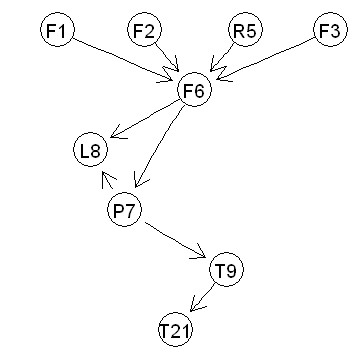

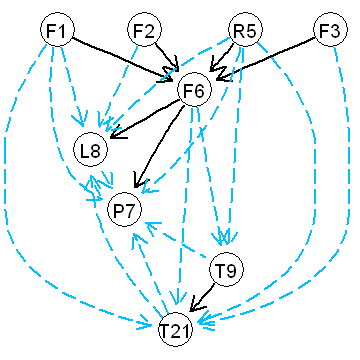

In [26]:
reactor1 = model2network("[F1][F2][F3][R5][T21|T9][T9|P7][P7|F6][L8|F6:P7][F6|F1:F2:F3:R5]")
garbage = compare_models(reactor, reactor1)
compare_graph(reactor1, reactor)

<span style="color:green"><font size="5"><b>[Reactor] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [35]:
rbind(Reactor_mod, Reactor, reactor_0, reactor_3a, reactor_3d)

,aic,bic,bge,loglike
Reactor_mod,0.375,0.2142857,0.2142857,0.6923077
Reactor,0.3428571,0.2,0.2,0.5
reactor_0,0.2857143,0.2068966,0.2068966,0.3859649
reactor_3a,0.3243243,0.0625,0.1935484,0.3508772
reactor_3d,0.2777778,0.07407407,0.1428571,0.3928571


<hr>

<hr>

<span style="color:red"><font size="6"><b>7c. CONDENSER...</b></font></span>

### [Condenser] 3 configurations: 1 true and 2 randoms

In [36]:
condenser <- model2network("[T9][T22|T9]")
condenser_rnd1 <- random.graph(nodes = c( "T22", "T9"))
condenser_rnd2 <- random.graph(nodes = c( "T22", "T9"))

### [Condenser] Plotting graphs of all three configurations

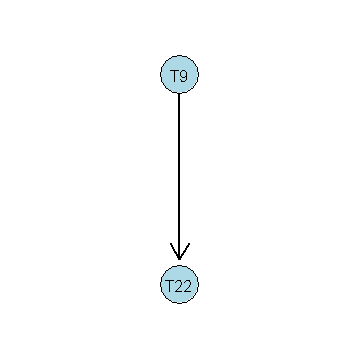

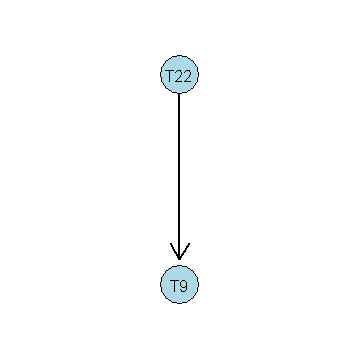

In [37]:
plot_graph(condenser)
plot_graph(condenser_rnd1)
plot_graph(condenser_rnd2)

### [Condenser] Fitting each of the three into linear gaussian model.

In [39]:
gaussian_condenser <- gaussian(condenser, read_data("condenser", "1a"))
gaussian_condenser_rnd1 <- gaussian(condenser_rnd1, read_data("condenser", "1a"))
gaussian_condenser_rnd2 <- gaussian(condenser_rnd2, read_data("condenser", "1a"))

[1] "[T9][T22|T9]"
[1] "[T22][T9|T22]"
[1] "[T22][T9|T22]"


### [Condenser] Comparing scores across 3 configurations and 4 datasets.

In [40]:
compare_scores(condenser, condenser_rnd1, condenser_rnd2, "condenser")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-2832.883,-2835.883,-2843.246,-2845.225,-2838.674,-2841.674,-2849.037,-2850.994,-2839.693,-2842.693,-2850.056,-2852.009,-2838.674,-2841.674,-2849.037,-2850.994
-2832.883,-2835.883,-2843.246,-2845.225,-2838.674,-2841.674,-2849.037,-2850.994,-2839.693,-2842.693,-2850.056,-2852.009,-2838.674,-2841.674,-2849.037,-2850.994
-2832.883,-2835.883,-2843.246,-2845.225,-2838.674,-2841.674,-2849.037,-2850.994,-2839.693,-2842.693,-2850.056,-2852.009,-2838.674,-2841.674,-2849.037,-2850.994


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Condenser] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BIC, dataset = 1a


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BGE, dataset = 1a


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


DAG [AIC]:  [T9][T22|T9]
DAG [BIC]:  [T9][T22|T9]
DAG [BGe]:  [T9][T22|T9]
DAG [Loglike]:  [T9][T22|T9]


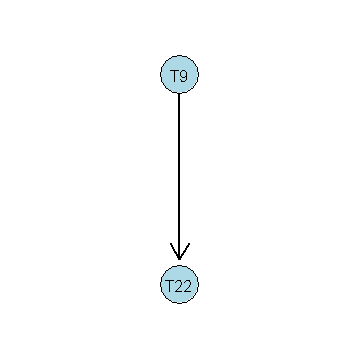

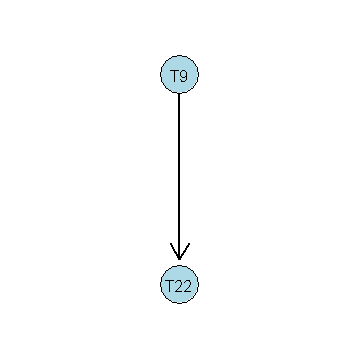

In [41]:
Condenser = learn_structure(condenser, "condenser", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BIC, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BGE, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


DAG [AIC]:  [T9][T22|T9]
DAG [BIC]:  [T9][T22|T9]
DAG [BGe]:  [T9][T22|T9]
DAG [Loglike]:  [T9][T22|T9]


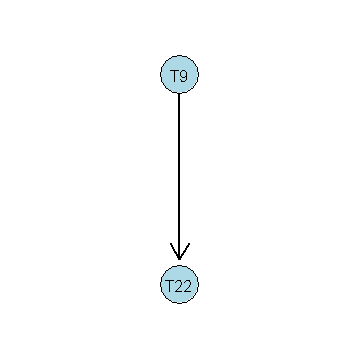

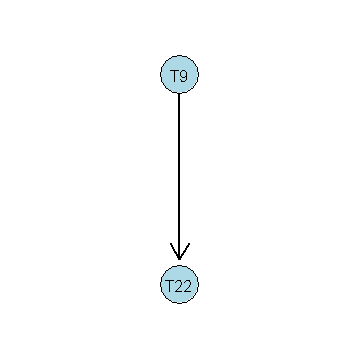

In [42]:
condenser_0 = learn_structure(condenser, "condenser", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BIC, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 3a


[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."DAG [AIC]:  [T9][T22]
DAG [BIC]:  [T9][T22]
DAG [BGe]:  [T9][T22]
DAG [Loglike]:  [T9][T22|T9]


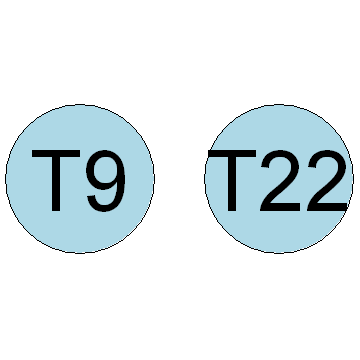

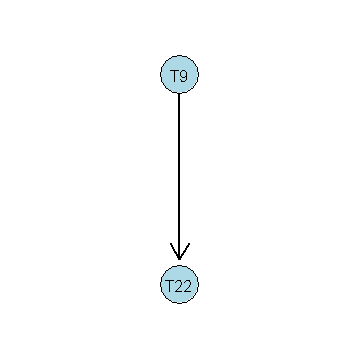

In [43]:
condenser_3a = learn_structure(condenser, "condenser", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BIC, dataset = 3d


[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = BGE, dataset = 3d


[1] "True Positive          =  0"
[1] "False Positive         =  1"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  NaN"
[1] "Precision              =  0"
[1] "F1 score               =  0"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."Warning message in graphviz.backend(nodes = nodes, arcs = arcs, highlight = highlight, :
"no arc to apply the 'lwd' setting to, ignoring."

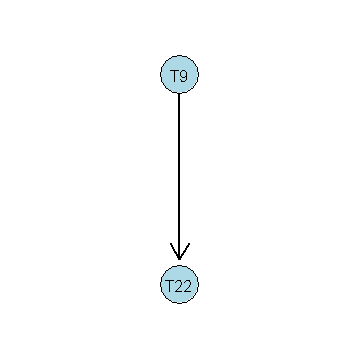

DAG [AIC]:  [T9][T22|T9]
DAG [BIC]:  [T9][T22]
DAG [BGe]:  [T9][T22]
DAG [Loglike]:  [T9][T22|T9]


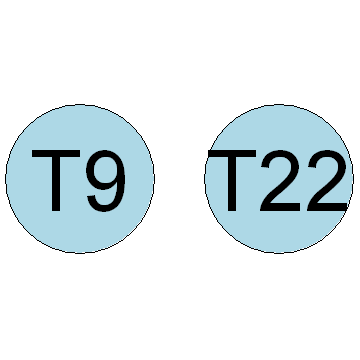

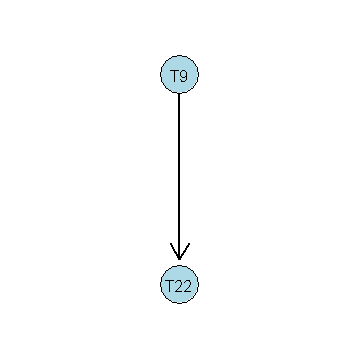

In [44]:
condenser_3d = learn_structure(condenser, "condenser", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on CONDENSER structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BIC, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = BGE, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  0"
[1] "False Negative         =  0"
[1] "Recall (sensitivity)   =  1"
[1] "Precision              =  1"
[1] "F1 score               =  1"


DAG [AIC]:  [T9][T22|T9]
DAG [BIC]:  [T9][T22|T9]
DAG [BGe]:  [T9][T22|T9]
DAG [Loglike]:  [T9][T22|T9]


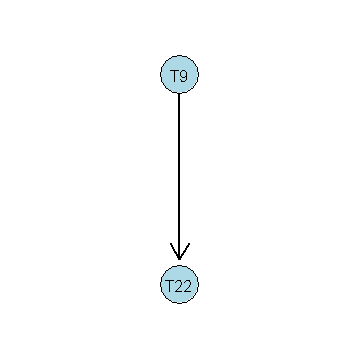

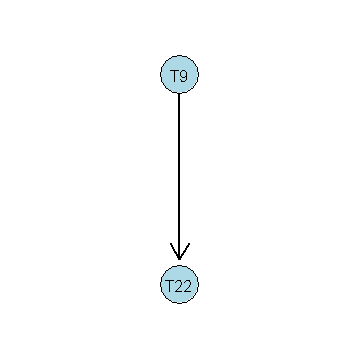

In [45]:
from2  = c("T22")
to2 = c("T9")
black_condenser = data.frame("from"=from2, "to"=to2)
Condenser_mod = learn_structure(condenser, "condenser", "0", whitelist = NULL, blacklist = black_condenser)

<span style="color:green"><font size="5"><b>[Condenser] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [46]:
rbind(Condenser_mod, Condenser, condenser_0, condenser_3a, condenser_3d)

,aic,bic,bge,loglike
Condenser_mod,1,1,1,1
Condenser,1,1,1,1
condenser_0,1,1,1,1
condenser_3a,0,0,0,1
condenser_3d,1,0,0,1


<hr>

<hr>

<span style="color:red"><font size="6"><b>7d. SEPARATOR...</b></font></span>

### [Separator] 3 configurations: 1 true and 2 randoms

In [47]:
separator <- model2network("[T9][T22|T9][L8][P7|L8][T11|T22:T9:L8][L12|P7:L8:P13][P13|P7:L8:T22][F14|P7:L8:L12:T22:T11]")
separator_rnd1 <- random.graph(nodes = c("P7", "L8", "T9", "T22", "T11", "L12", "P13", "F14"))
separator_rnd2 <- random.graph(nodes = c("P7", "L8", "T9", "T22", "T11", "L12", "P13", "F14"))

### [Separator] Plotting graphs of all three configurations

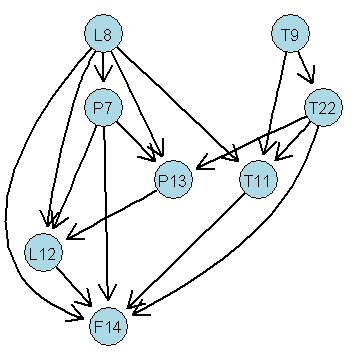

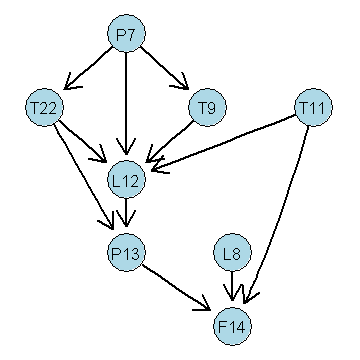

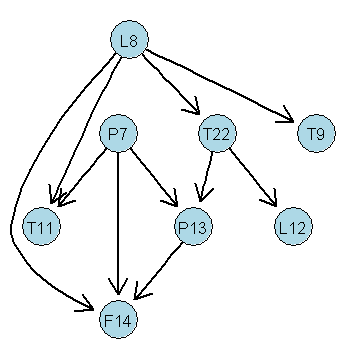

In [48]:
plot_graph(separator)
plot_graph(separator_rnd1)
plot_graph(separator_rnd2)

### [Separator] Fitting each of the three into linear gaussian model.

In [50]:
gaussian_separator <- gaussian(separator, read_data("separator", "1a"))
gaussian_separator_rnd1 <- gaussian(separator_rnd1, read_data("separator", "1a"))
gaussian_separator_rnd2 <- gaussian(separator_rnd2, read_data("separator", "1a"))

[1] "[L8][T9][P7|L8][T22|T9][P13|L8:P7:T22][T11|L8:T22:T9][L12|L8:P13:P7][F14|L12:L8:P7:T11:T22]"
[1] "[P7][L8][T11][T9|P7][T22|P7][L12|P7:T9:T22:T11][P13|T22:L12][F14|L8:T11:P13]"
[1] "[P7][L8][T9|L8][T22|L8][T11|P7:L8][L12|T22][P13|P7:T22][F14|P7:L8:P13]"


### [Separator] Comparing scores across 3 configurations and 4 datasets.

In [51]:
compare_scores(separator, separator_rnd1, separator_rnd2, "separator")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-10285.97,-10309.97,-10368.88,-10390.86,-10302.62,-10326.62,-10385.53,-10417.99,-10195.36,-10219.36,-10278.27,-10322.17,-10302.62,-10326.62,-10385.53,-10417.99
-11315.95,-11334.95,-11381.58,-11384.00,-10302.62,-10326.62,-10385.53,-10417.99,-11320.30,-11339.30,-11385.93,-11388.33,-11326.46,-11345.46,-11392.09,-11394.47
-10454.22,-10472.22,-10516.40,-10542.97,-10302.62,-10326.62,-10385.53,-10417.99,-10173.56,-10191.56,-10235.74,-10285.17,-10305.01,-10323.01,-10367.19,-10405.16


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Separator] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  3"
[1] "False Positive         =  13"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.1875"
[1] "F1 score               =  0.24"


score = BIC, dataset = 1a


[1] "True Positive          =  2"
[1] "False Positive         =  14"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.125"
[1] "F1 score               =  0.181818181818182"


score = BGE, dataset = 1a


[1] "True Positive          =  2"
[1] "False Positive         =  14"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.125"
[1] "F1 score               =  0.181818181818182"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  11"
[1] "False Positive         =  5"
[1] "False Negative         =  15"
[1] "Recall (sensitivity)   =  0.423076923076923"
[1] "Precision              =  0.6875"
[1] "F1 score               =  0.523809523809524"


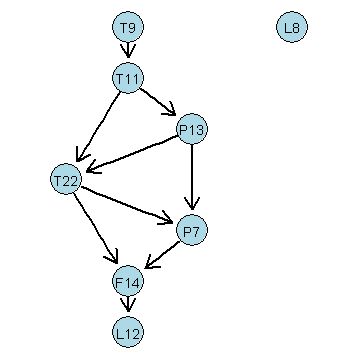

DAG [AIC]:  [L8][T9][T11|T9][P13|T11][T22|T11:P13][P7|T22:P13][F14|P7:T22][L12|F14]
DAG [BIC]:  [P7][L8][L12][F14][P13|P7][T22|P7:P13][T11|T22:P13][T9|T11]
DAG [BGe]:  [P7][L8][L12][F14][P13|P7][T22|P7:P13][T11|T22:P13][T9|T11]
DAG [Loglike]:  [P7][L8|P7][P13|P7:L8][T22|P7:L8:P13][T9|P7:L8:T22:P13][L12|P7:L8:T22:P13][F14|P7:L8:T9:T22:L12:P13][T11|P7:T9:T22:L12:P13:F14]


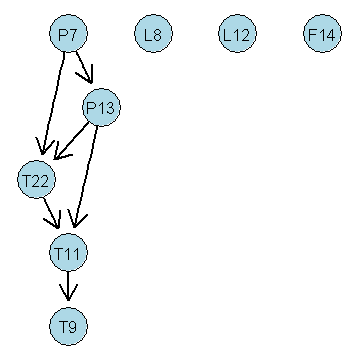

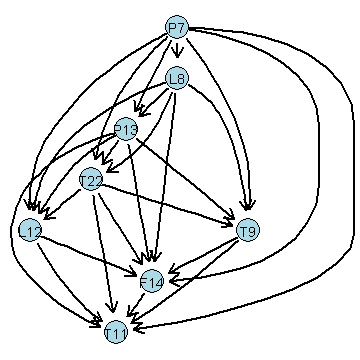

In [52]:
Separator = learn_structure(separator, "separator", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  7"
[1] "False Positive         =  9"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.538461538461538"
[1] "Precision              =  0.4375"
[1] "F1 score               =  0.482758620689655"


score = BIC, dataset = 0


[1] "True Positive          =  1"
[1] "False Positive         =  15"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.0625"
[1] "F1 score               =  0.0952380952380952"


score = BGE, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  12"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.25"
[1] "F1 score               =  0.32"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  10"
[1] "False Positive         =  6"
[1] "False Negative         =  17"
[1] "Recall (sensitivity)   =  0.37037037037037"
[1] "Precision              =  0.625"
[1] "F1 score               =  0.465116279069767"


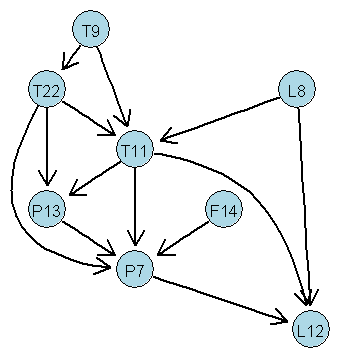

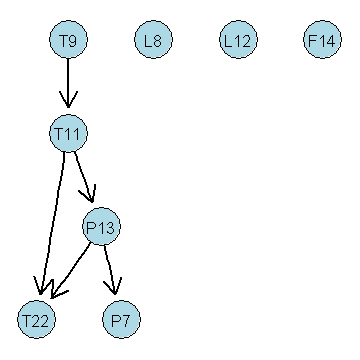

DAG [AIC]:  [L8][T9][F14][T22|T9][T11|L8:T9:T22][P13|T22:T11][P7|T22:T11:P13:F14][L12|P7:L8:T11]
DAG [BIC]:  [L8][T9][L12][F14][T11|T9][P13|T11][P7|P13][T22|T11:P13]
DAG [BGe]:  [L8][T9][L12][F14][T11|T9][T22|T9:T11][P7|T22:T11][P13|P7:T22:T11:F14]
DAG [Loglike]:  [P7][L8|P7][L12|P7:L8][T11|P7:L8:L12][F14|P7:L8:T11:L12][P13|P7:L8:T11:L12:F14][T9|L8:T11:L12:P13:F14][T22|P7:L8:T9:T11:L12:P13:F14]


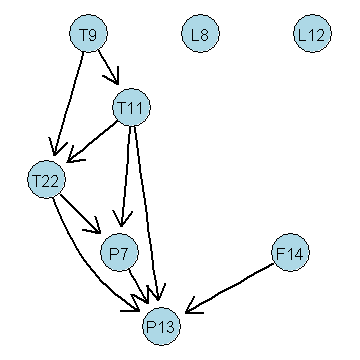

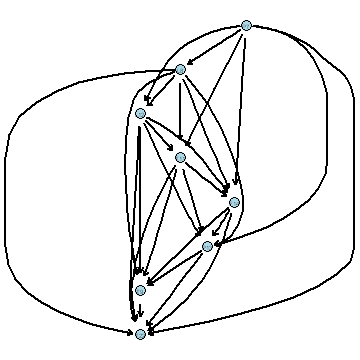

In [53]:
separator_0 = learn_structure(separator, "separator", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  5"
[1] "False Positive         =  11"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.454545454545455"
[1] "Precision              =  0.3125"
[1] "F1 score               =  0.37037037037037"


score = BIC, dataset = 3a


[1] "True Positive          =  2"
[1] "False Positive         =  14"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.4"
[1] "Precision              =  0.125"
[1] "F1 score               =  0.19047619047619"


score = BGE, dataset = 3a


[1] "True Positive          =  3"
[1] "False Positive         =  13"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.1875"
[1] "F1 score               =  0.272727272727273"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  11"
[1] "False Positive         =  5"
[1] "False Negative         =  17"
[1] "Recall (sensitivity)   =  0.392857142857143"
[1] "Precision              =  0.6875"
[1] "F1 score               =  0.5"


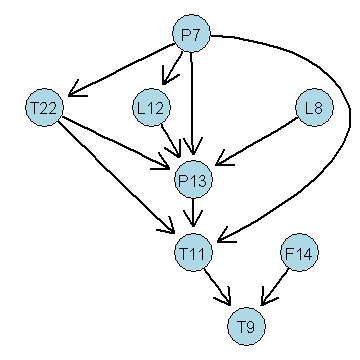

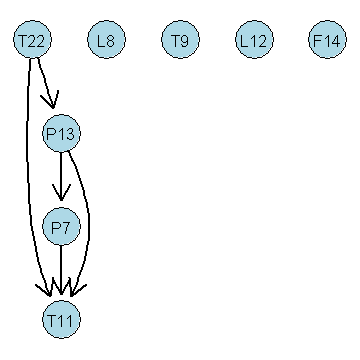

DAG [AIC]:  [P7][L8][F14][T22|P7][L12|P7][P13|P7:L8:T22:L12][T11|P7:T22:P13][T9|T11:F14]
DAG [BIC]:  [L8][T9][T22][L12][F14][P13|T22][P7|P13][T11|P7:T22:P13]
DAG [BGe]:  [P7][L8][T9][L12][F14][T22|P7][T11|P7:T22][P13|P7:T22:T11]
DAG [Loglike]:  [T22][T11|T22][P7|T22:T11][T9|P7:T22:T11][L8|P7:T9:T22:T11][F14|P7:L8:T9:T22:T11][P13|P7:L8:T9:T22:T11:F14][L12|P7:L8:T9:T22:T11:P13:F14]


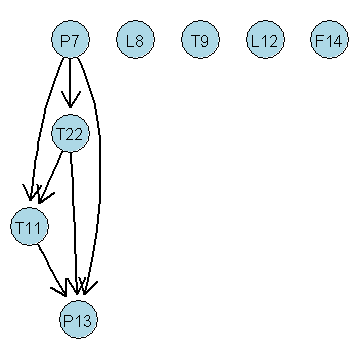

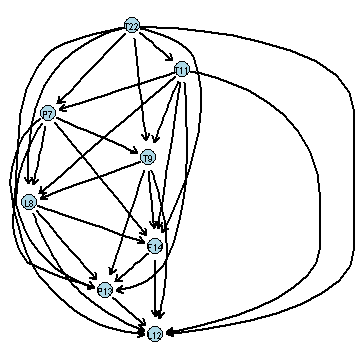

In [54]:
separator_3a = learn_structure(separator, "separator", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  15"
[1] "False Negative         =  12"
[1] "Recall (sensitivity)   =  0.0769230769230769"
[1] "Precision              =  0.0625"
[1] "F1 score               =  0.0689655172413793"


score = BIC, dataset = 3d


[1] "True Positive          =  2"
[1] "False Positive         =  14"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.285714285714286"
[1] "Precision              =  0.125"
[1] "F1 score               =  0.173913043478261"


score = BGE, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  15"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.125"
[1] "Precision              =  0.0625"
[1] "F1 score               =  0.0833333333333333"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  10"
[1] "False Positive         =  6"
[1] "False Negative         =  17"
[1] "Recall (sensitivity)   =  0.37037037037037"
[1] "Precision              =  0.625"
[1] "F1 score               =  0.465116279069767"


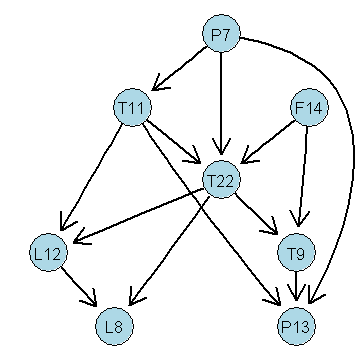

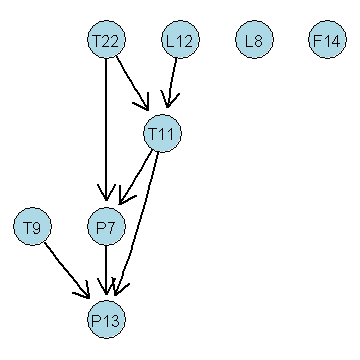

DAG [AIC]:  [P7][F14][T11|P7][T22|P7:T11:F14][T9|T22:F14][L12|T22:T11][L8|T22:L12][P13|P7:T9:T11]
DAG [BIC]:  [L8][T9][T22][L12][F14][T11|T22:L12][P7|T22:T11][P13|P7:T9:T11]
DAG [BGe]:  [L8][T9][T11][F14][L12|T11][T22|T11:L12][P7|T22:T11][P13|P7:T9:T11]
DAG [Loglike]:  [L8][T22|L8][F14|L8:T22][T9|L8:T22:F14][P7|T9:T22:F14][T11|P7:L8:T9:T22:F14][L12|P7:L8:T9:T22:T11:F14][P13|P7:L8:T9:T22:T11:L12:F14]


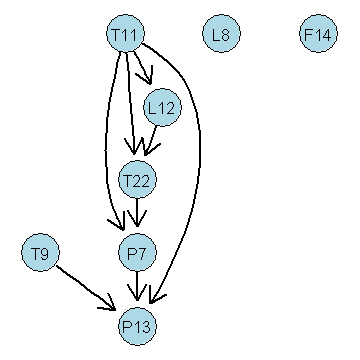

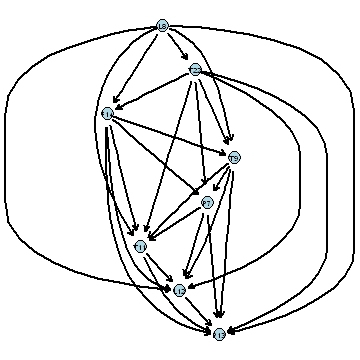

In [55]:
separator_3d = learn_structure(separator, "separator", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on SEPARATOR structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  8"
[1] "False Positive         =  8"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.615384615384615"
[1] "Precision              =  0.5"
[1] "F1 score               =  0.551724137931034"


score = BIC, dataset = 0


[1] "True Positive          =  5"
[1] "False Positive         =  11"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.714285714285714"
[1] "Precision              =  0.3125"
[1] "F1 score               =  0.434782608695652"


score = BGE, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  12"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.25"
[1] "F1 score               =  0.32"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  13"
[1] "False Positive         =  3"
[1] "False Negative         =  15"
[1] "Recall (sensitivity)   =  0.464285714285714"
[1] "Precision              =  0.8125"
[1] "F1 score               =  0.590909090909091"


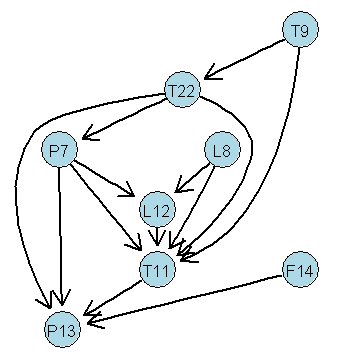

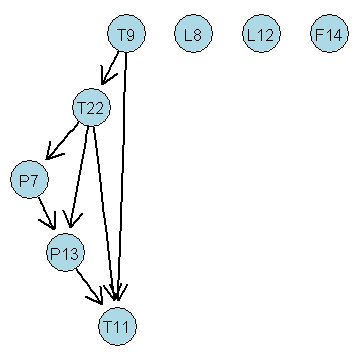

DAG [AIC]:  [L8][T9][F14][T22|T9][P7|T22][L12|P7:L8][T11|P7:L8:T9:T22:L12][P13|P7:T22:T11:F14]
DAG [BIC]:  [L8][T9][L12][F14][T22|T9][P7|T22][P13|P7:T22][T11|T9:T22:P13]
DAG [BGe]:  [P7][L8][L12][F14][T22|P7][T9|T22][T11|P7:T9:T22][P13|P7:T22:T11:F14]
DAG [Loglike]:  [P7][L8|P7][T22|P7:L8][T9|P7:L8:T22][L12|P7:L8:T9:T22][T11|P7:L8:T9:T22:L12][F14|P7:L8:T9:T22:T11:L12][P13|P7:L8:T9:T22:T11:L12:F14]


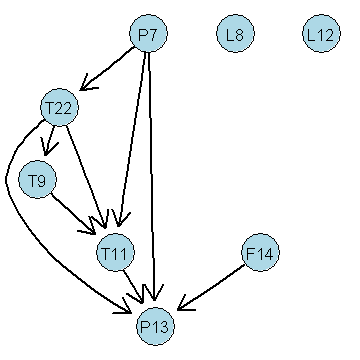

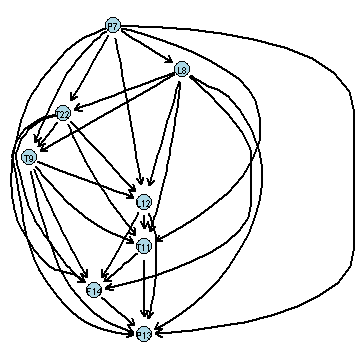

In [56]:
from2  = c("T11", "T11", "T11", "T11", "L12", "L12", "L12", "L12", "P13", "P13", "P13", "P13", "F14", "F14", "F14", "F14")
to2 = c("P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22")
black_separator = data.frame("from"=from2, "to"=to2)
Separator_mod = learn_structure(separator, "separator", "0", whitelist = NULL, blacklist = black_separator)

<span style="color:green"><font size="5"><b>[Separator] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [57]:
rbind(Separator_mod, Separator, separator_0, separator_3a, separator_3d)

,aic,bic,bge,loglike
Separator_mod,0.5517241,0.4347826,0.32,0.5909091
Separator,0.24,0.1818182,0.1818182,0.5238095
separator_0,0.4827586,0.0952381,0.32,0.4651163
separator_3a,0.3703704,0.1904762,0.2727273,0.5
separator_3d,0.06896552,0.173913,0.08333333,0.4651163


<hr>

<hr>

<span style="color:red"><font size="6"><b>7e. STRIPPER...</b></font></span>

### [Stripper] 3 configurations: 1 true and 2 randoms

In [58]:
stripper <- model2network("[F4][T11][F14|T11:L12][P13][L12|P13][L15|F14:F4:T11:L12][P16|T11:L12:P13:F14:F4:L15:F17:T18][F17|L12:P13:F14:L15:F19][T18|L12:P13:F14:L15:F4][F19|F4:T18]")
stripper_rnd1 <- random.graph(nodes = c("T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19"))
stripper_rnd2 <- random.graph(nodes = c("T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19"))

### [Stripper] Plotting graphs of all three configurations

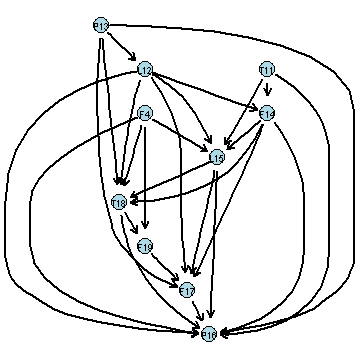

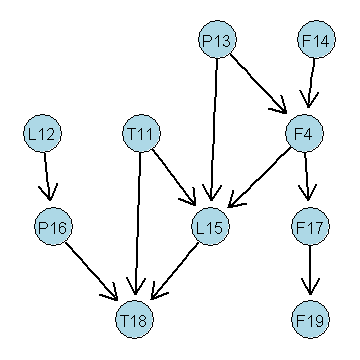

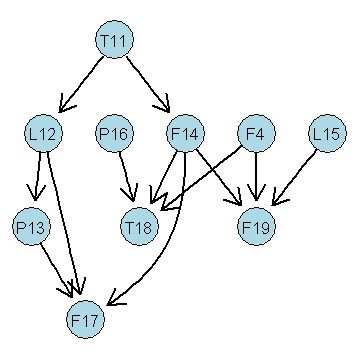

In [59]:
plot_graph(stripper)
plot_graph(stripper_rnd1)
plot_graph(stripper_rnd2)

### [Stripper] Fitting each of the three into linear gaussian model.

In [61]:
gaussian_stripper <- gaussian(stripper, read_data("stripper", "1a"))
gaussian_stripper_rnd1 <- gaussian(stripper_rnd1, read_data("stripper", "1a"))
gaussian_stripper_rnd2 <- gaussian(stripper_rnd2, read_data("stripper", "1a"))

[1] "[F4][P13][T11][L12|P13][F14|L12:T11][L15|F14:F4:L12:T11][T18|F14:F4:L12:L15:P13][F19|F4:T18][F17|F14:F19:L12:L15:P13][P16|F14:F17:F4:L12:L15:P13:T11:T18]"
[1] "[T11][L12][P13][F14][F4|P13:F14][P16|L12][L15|T11:P13:F4][F17|F4][T18|T11:L15:P16][F19|F17]"
[1] "[T11][F4][L15][P16][L12|T11][F14|T11][P13|L12][T18|F14:F4:P16][F19|F14:F4:L15][F17|L12:P13:F14]"


### [Stripper] Comparing scores across 3 configurations and 4 datasets.

In [62]:
compare_scores(stripper, stripper_rnd1, stripper_rnd2, "stripper")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-13280.56,-13317.56,-13408.37,-13420.08,-13611.38,-13648.38,-13739.2,-13735.74,-13495.75,-13532.75,-13623.56,-13622.65,-13611.38,-13648.38,-13739.20,-13735.74
-13807.60,-13828.60,-13880.15,-13888.37,-13611.38,-13648.38,-13739.2,-13735.74,-13809.80,-13830.80,-13882.34,-13890.67,-13830.53,-13851.53,-13903.07,-13911.04
-14169.58,-14191.58,-14245.58,-14249.84,-13611.38,-13648.38,-13739.2,-13735.74,-14050.27,-14072.27,-14126.26,-14131.03,-14057.63,-14079.63,-14133.63,-14138.34


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Stripper] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  6"
[1] "False Positive         =  21"
[1] "False Negative         =  10"
[1] "Recall (sensitivity)   =  0.375"
[1] "Precision              =  0.222222222222222"
[1] "F1 score               =  0.27906976744186"


score = BIC, dataset = 1a


[1] "True Positive          =  3"
[1] "False Positive         =  24"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.111111111111111"
[1] "F1 score               =  0.181818181818182"


score = BGE, dataset = 1a


[1] "True Positive          =  2"
[1] "False Positive         =  25"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.333333333333333"
[1] "Precision              =  0.0740740740740741"
[1] "F1 score               =  0.121212121212121"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  13"
[1] "False Positive         =  14"
[1] "False Negative         =  29"
[1] "Recall (sensitivity)   =  0.30952380952381"
[1] "Precision              =  0.481481481481481"
[1] "F1 score               =  0.376811594202899"


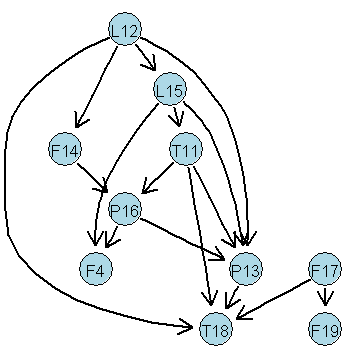

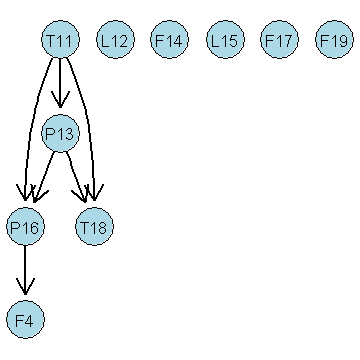

DAG [AIC]:  [L12][F17][F14|L12][L15|L12][F19|F17][T11|L15][P16|T11:F14][P13|T11:L12:L15:P16][F4|L15:P16][T18|T11:L12:P13:F17]
DAG [BIC]:  [T11][L12][F14][L15][F17][F19][P13|T11][P16|T11:P13][T18|T11:P13][F4|P16]
DAG [BGe]:  [T11][L12][F14][L15][F17][F19][T18|T11][P13|T11:T18][F4|P13][P16|T11:P13]
DAG [Loglike]:  [T11][P13|T11][P16|T11:P13][T18|T11:P13:P16][F14|T11:P13:P16:T18][F19|T11:P13:F14:P16:T18][L12|P13:F14:P16:T18:F19][L15|T11:L12:P13:F14:P16:T18:F19][F17|T11:P13:F14:L15:P16:T18:F19][F4|T11:L12:F14:L15:P16:F17:T18:F19]


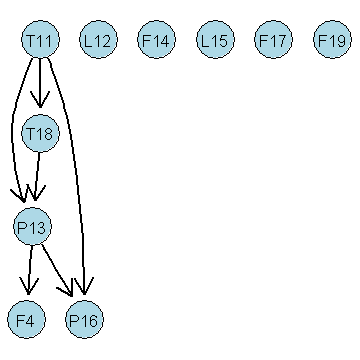

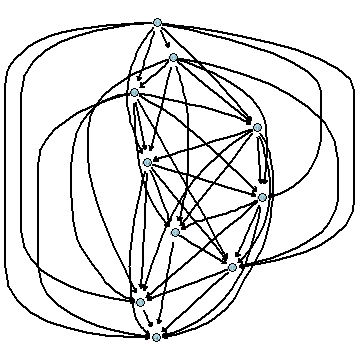

In [63]:
Stripper = learn_structure(stripper, "stripper", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  7"
[1] "False Positive         =  20"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.259259259259259"
[1] "F1 score               =  0.341463414634146"


score = BIC, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  23"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.571428571428571"
[1] "Precision              =  0.148148148148148"
[1] "F1 score               =  0.235294117647059"


score = BGE, dataset = 0


[1] "True Positive          =  3"
[1] "False Positive         =  24"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.428571428571429"
[1] "Precision              =  0.111111111111111"
[1] "F1 score               =  0.176470588235294"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  22"
[1] "False Positive         =  5"
[1] "False Negative         =  22"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.814814814814815"
[1] "F1 score               =  0.619718309859155"


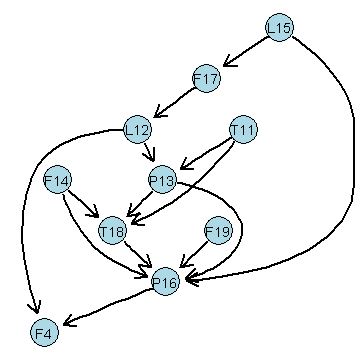

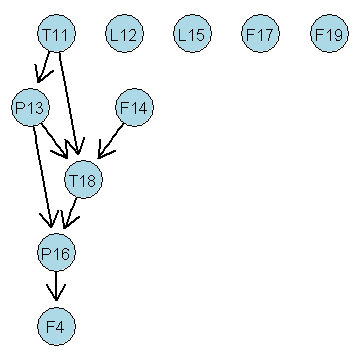

DAG [AIC]:  [T11][F14][L15][F19][F17|L15][L12|F17][P13|T11:L12][T18|T11:P13:F14][P16|P13:F14:L15:T18:F19][F4|L12:P16]
DAG [BIC]:  [T11][L12][F14][L15][F17][F19][P13|T11][T18|T11:P13:F14][P16|P13:T18][F4|P16]
DAG [BGe]:  [T11][L12][F14][L15][F17][F19][T18|T11:F14][P13|T11:T18][P16|P13:T18][F4|P16]
DAG [Loglike]:  [T11][L12|T11][F4|T11:L12][T18|T11:L12:F4][F14|T11:L12:F4:T18][L15|T11:L12:F14:F4:T18][F19|T11:L12:F14:F4:L15:T18][P13|T11:L12:F14:F4:L15:T18:F19][F17|T11:L12:F14:F4:L15:T18:F19][P16|T11:L12:P13:F14:F4:L15:F17:T18:F19]


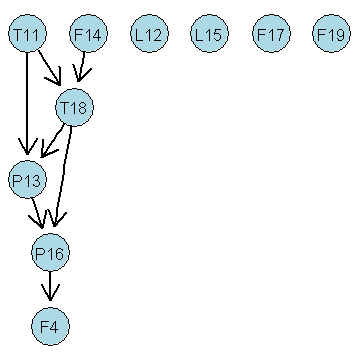

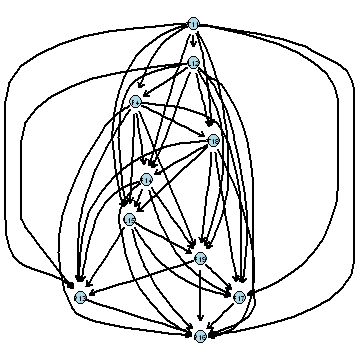

In [64]:
stripper_0 = learn_structure(stripper, "stripper", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  6"
[1] "False Positive         =  21"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.545454545454545"
[1] "Precision              =  0.222222222222222"
[1] "F1 score               =  0.315789473684211"


score = BIC, dataset = 3a


[1] "True Positive          =  2"
[1] "False Positive         =  25"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.4"
[1] "Precision              =  0.0740740740740741"
[1] "F1 score               =  0.125"


score = BGE, dataset = 3a


[1] "True Positive          =  3"
[1] "False Positive         =  24"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.428571428571429"
[1] "Precision              =  0.111111111111111"
[1] "F1 score               =  0.176470588235294"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  19"
[1] "False Positive         =  8"
[1] "False Negative         =  24"
[1] "Recall (sensitivity)   =  0.441860465116279"
[1] "Precision              =  0.703703703703704"
[1] "F1 score               =  0.542857142857143"


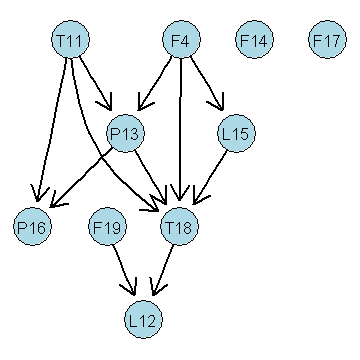

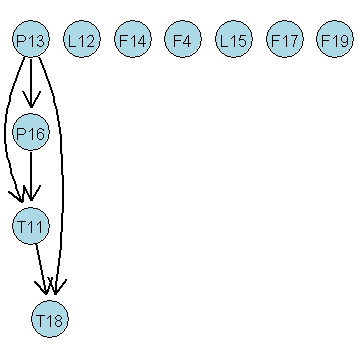

DAG [AIC]:  [T11][F14][F4][F17][F19][P13|T11:F4][L15|F4][P16|T11:P13][T18|T11:P13:F4:L15][L12|T18:F19]
DAG [BIC]:  [L12][P13][F14][F4][L15][F17][F19][P16|P13][T11|P13:P16][T18|T11:P13]
DAG [BGe]:  [T11][L12][F14][F4][L15][F17][P16|T11:F4][F19|L12][P13|T11:P16][T18|T11:P13]
DAG [Loglike]:  [L12][F4|L12][P13|L12:F4][T18|L12:P13][T11|L12:P13:F4:T18][F17|T11:L12:P13:T18][L15|T11:L12:P13:F4:F17:T18][F14|T11:L12:P13:F4:L15:F17:T18][P16|T11:L12:P13:F14:F4:L15:F17:T18][F19|T11:L12:P13:F14:F4:L15:P16:F17:T18]


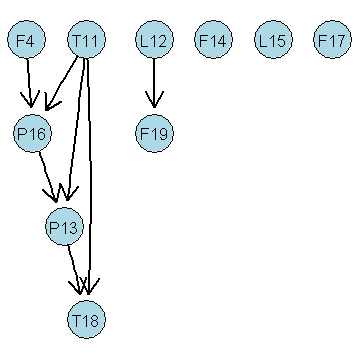

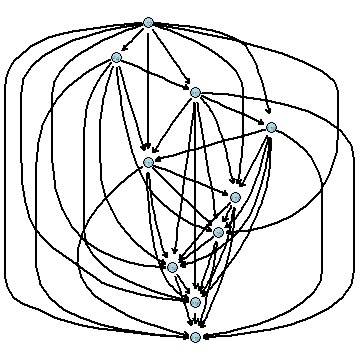

In [65]:
stripper_3a = learn_structure(stripper, "stripper", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  3"
[1] "False Positive         =  24"
[1] "False Negative         =  9"
[1] "Recall (sensitivity)   =  0.25"
[1] "Precision              =  0.111111111111111"
[1] "F1 score               =  0.153846153846154"


score = BIC, dataset = 3d


[1] "True Positive          =  3"
[1] "False Positive         =  24"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.428571428571429"
[1] "Precision              =  0.111111111111111"
[1] "F1 score               =  0.176470588235294"


score = BGE, dataset = 3d


[1] "True Positive          =  2"
[1] "False Positive         =  25"
[1] "False Negative         =  7"
[1] "Recall (sensitivity)   =  0.222222222222222"
[1] "Precision              =  0.0740740740740741"
[1] "F1 score               =  0.111111111111111"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  20"
[1] "False Positive         =  7"
[1] "False Negative         =  24"
[1] "Recall (sensitivity)   =  0.454545454545455"
[1] "Precision              =  0.740740740740741"
[1] "F1 score               =  0.563380281690141"


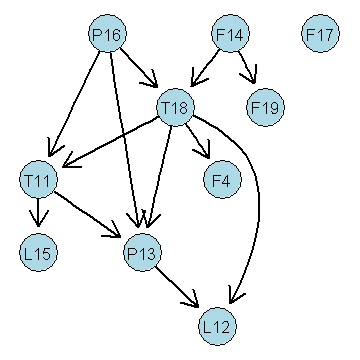

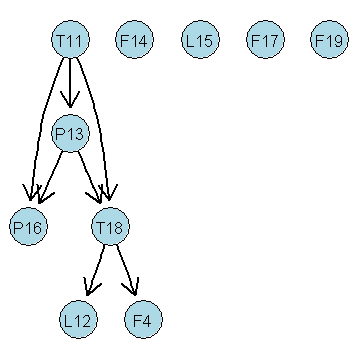

DAG [AIC]:  [F14][P16][F17][T18|F14:P16][F19|F14][T11|P16:T18][F4|T18][P13|T11:P16:T18][L15|T11][L12|P13:T18]
DAG [BIC]:  [T11][F14][L15][F17][F19][P13|T11][P16|T11:P13][T18|T11:P13][L12|T18][F4|T18]
DAG [BGe]:  [L12][F14][L15][P16][F17][F19][P13|P16][T18|L12:P13:P16][T11|P13:L15:P16:T18][F4|T18]
DAG [Loglike]:  [T11][L12|T11][F14|T11:L12][L15|T11:L12:F14][P16|T11:L12:F14:L15][P13|T11:L12:F14:L15:P16][F4|T11:L12:P13:F14:L15:P16][F19|T11:L12:P13:F14:F4:L15:P16][T18|T11:L12:P13:F14:F4:L15:P16:F19][F17|L12:P13:F14:F4:L15:P16:T18:F19]


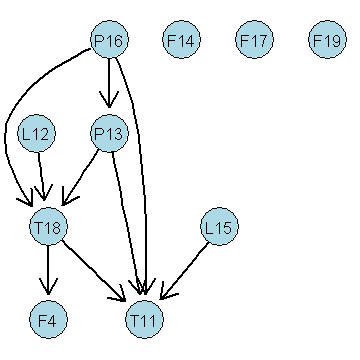

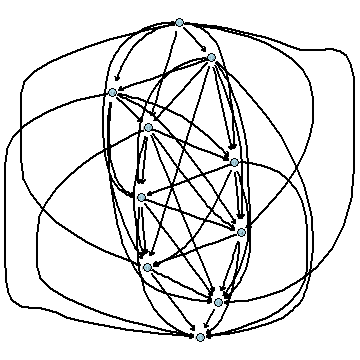

In [66]:
stripper_3d = learn_structure(stripper, "stripper", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on STRIPPER structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  8"
[1] "False Positive         =  19"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.571428571428571"
[1] "Precision              =  0.296296296296296"
[1] "F1 score               =  0.390243902439024"


score = BIC, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  23"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.571428571428571"
[1] "Precision              =  0.148148148148148"
[1] "F1 score               =  0.235294117647059"


score = BGE, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  23"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.571428571428571"
[1] "Precision              =  0.148148148148148"
[1] "F1 score               =  0.235294117647059"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  24"
[1] "False Positive         =  3"
[1] "False Negative         =  19"
[1] "Recall (sensitivity)   =  0.558139534883721"
[1] "Precision              =  0.888888888888889"
[1] "F1 score               =  0.685714285714286"


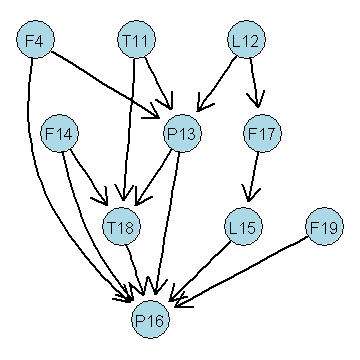

DAG [AIC]:  [T11][L12][F14][F4][F19][P13|T11:L12:F4][F17|L12][L15|F17][T18|T11:P13:F14][P16|P13:F14:F4:L15:T18:F19]
DAG [BIC]:  [L12][F14][F4][L15][F17][F19][P13|F4][T11|P13][T18|T11:P13:F14][P16|P13:T18]
DAG [BGe]:  [L12][F14][F4][L15][F17][F19][P13|F4][T11|P13][T18|T11:P13:F14][P16|P13:T18]
DAG [Loglike]:  [F4][L12|F4][T11|L12:F4][P13|T11:L12:F4][F14|T11:L12:P13:F4][L15|T11:L12:P13:F14:F4][T18|T11:L12:P13:F14:F4:L15][F17|T11:L12:F14:F4:L15:T18][F19|T11:L12:P13:F4:L15:F17:T18][P16|T11:L12:P13:F14:F4:L15:F17:T18:F19]


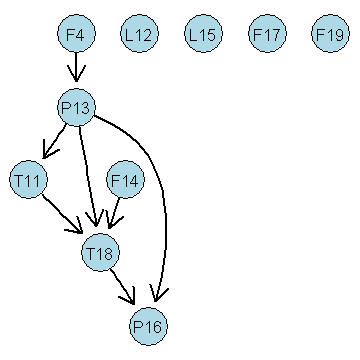

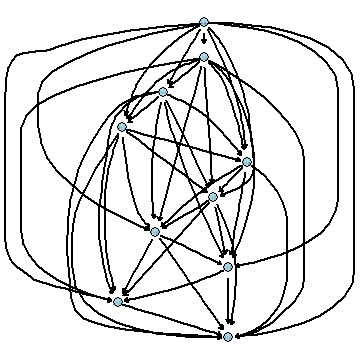

In [67]:
from2  = c("L15", "L15", "L15", "L15", "L15", "P16", "P16", "P16", "P16", "P16", "F17", "F17", "F17", "F17", "F17", "T18", "T18", "T18", "T18", "T18", "F19", "F19", "F19", "F19", "F19", "T11", "L12", "P13", "F14")
to2 = c("T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "F4", "F4", "F4", "F4")
black_stripper = data.frame("from"=from2, "to"=to2)
Stripper_mod = learn_structure(stripper, "stripper", "0", whitelist = NULL, blacklist = black_stripper)

<span style="color:green"><font size="5"><b>[Stripper] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [68]:
rbind(Stripper_mod, Stripper, stripper_0, stripper_3a, stripper_3d)

,aic,bic,bge,loglike
Stripper_mod,0.3902439,0.2352941,0.2352941,0.6857143
Stripper,0.2790698,0.1818182,0.1212121,0.3768116
stripper_0,0.3414634,0.2352941,0.1764706,0.6197183
stripper_3a,0.3157895,0.125,0.1764706,0.5428571
stripper_3d,0.1538462,0.1764706,0.1111111,0.5633803


<hr>

<hr>

<span style="color:red"><font size="6"><b>7f. COMPRESSOR...</b></font></span>

### [Compressor] 3 configurations: 1 true and 2 randoms

In [69]:
compressor <- model2network("[T11][P13][L12|P13][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|J20:F10:L12:P13:T11]")
compressor_rnd1 <- random.graph(nodes = c("F5", "T11", "L12", "P13", "F10", "J20"))
compressor_rnd2 <- random.graph(nodes = c("F5", "T11", "L12", "P13", "F10", "J20"))

### [Compressor] Plotting graphs of all three configurations

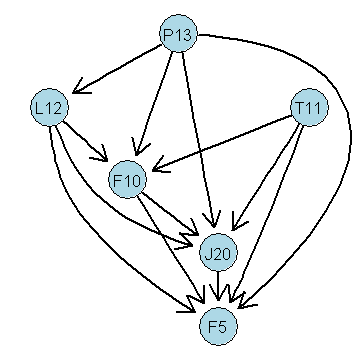

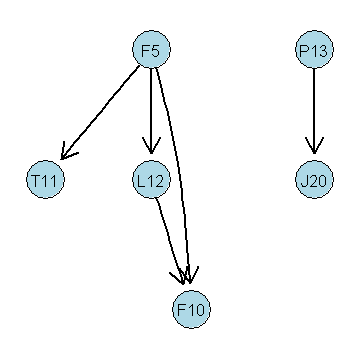

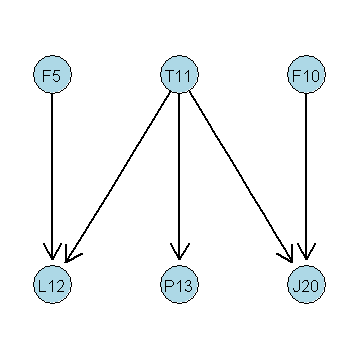

In [70]:
plot_graph(compressor)
plot_graph(compressor_rnd1)
plot_graph(compressor_rnd2)

### [Compressor] Fitting each of the three into linear gaussian model.

In [72]:
gaussian_compressor <- gaussian(compressor, read_data("compressor", "1a"))
gaussian_compressor_rnd1 <- gaussian(compressor_rnd1, read_data("compressor", "1a"))
gaussian_compressor_rnd2 <- gaussian(compressor_rnd2, read_data("compressor", "1a"))

[1] "[P13][T11][L12|P13][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|F10:J20:L12:P13:T11]"
[1] "[F5][P13][T11|F5][L12|F5][J20|P13][F10|F5:L12]"
[1] "[F5][T11][F10][L12|F5:T11][P13|T11][J20|T11:F10]"


### [Compressor] Comparing scores across 3 configurations and 4 datasets.

In [73]:
compare_scores(compressor, compressor_rnd1, compressor_rnd2, "compressor")

loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge,loglik,aic,bic,bge
-8403.213,-8422.213,-8468.846,-8467.214,-8210.125,-8229.125,-8275.758,-8275.182,-8258.609,-8277.609,-8324.243,-8323.232,-8210.125,-8229.125,-8275.758,-8275.182
-8505.309,-8516.309,-8543.308,-8547.552,-8210.125,-8229.125,-8275.758,-8275.182,-8444.059,-8455.059,-8482.057,-8486.595,-8395.363,-8406.363,-8433.362,-8438.231
-8402.067,-8413.067,-8440.065,-8444.766,-8210.125,-8229.125,-8275.758,-8275.182,-8418.174,-8429.174,-8456.172,-8460.790,-8430.417,-8441.417,-8468.415,-8472.984


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Compressor] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  5"
[1] "False Positive         =  8"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.555555555555556"
[1] "Precision              =  0.384615384615385"
[1] "F1 score               =  0.454545454545455"


score = BIC, dataset = 1a


[1] "True Positive          =  1"
[1] "False Positive         =  12"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.0769230769230769"
[1] "F1 score               =  0.111111111111111"


score = BGE, dataset = 1a


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.666666666666667"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.421052631578947"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  9"
[1] "False Positive         =  4"
[1] "False Negative         =  6"
[1] "Recall (sensitivity)   =  0.6"
[1] "Precision              =  0.692307692307692"
[1] "F1 score               =  0.642857142857143"


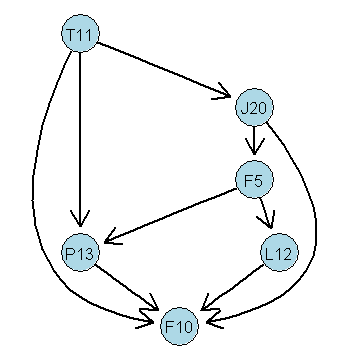

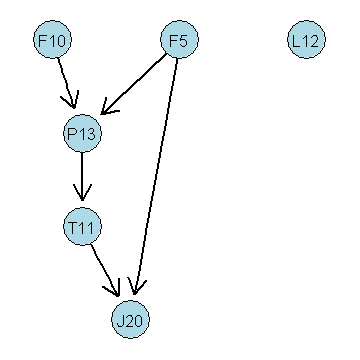

DAG [AIC]:  [T11][J20|T11][F5|J20][L12|F5][P13|F5:T11][F10|T11:L12:P13:J20]
DAG [BIC]:  [F5][L12][F10][P13|F5:F10][T11|P13][J20|F5:T11]
DAG [BGe]:  [T11][L12][J20|T11][F5|J20][P13|F5:T11][F10|L12:P13]
DAG [Loglike]:  [T11][P13|T11][F5|T11:P13][L12|F5:T11:P13][J20|F5:T11:L12:P13][F10|F5:T11:L12:P13:J20]


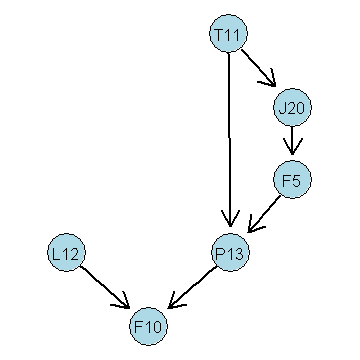

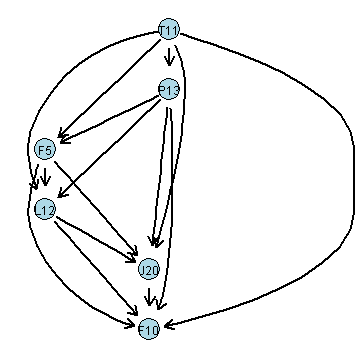

In [74]:
Compressor = learn_structure(compressor, "compressor", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.363636363636364"


score = BIC, dataset = 0


[1] "True Positive          =  5"
[1] "False Positive         =  8"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0.833333333333333"
[1] "Precision              =  0.384615384615385"
[1] "F1 score               =  0.526315789473684"


score = BGE, dataset = 0


[1] "True Positive          =  6"
[1] "False Positive         =  7"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0.857142857142857"
[1] "Precision              =  0.461538461538462"
[1] "F1 score               =  0.6"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  7"
[1] "False Positive         =  6"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.466666666666667"
[1] "Precision              =  0.538461538461538"
[1] "F1 score               =  0.5"


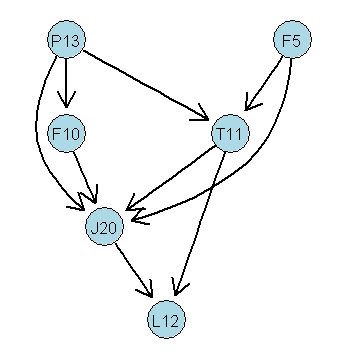

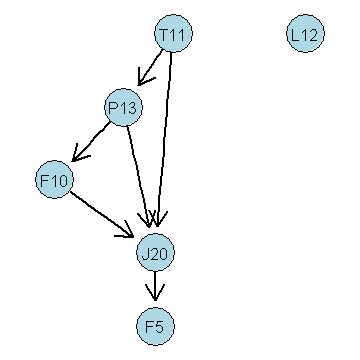

DAG [AIC]:  [F5][P13][T11|F5:P13][F10|P13][J20|F5:T11:P13:F10][L12|T11:J20]
DAG [BIC]:  [T11][L12][P13|T11][F10|P13][J20|T11:P13:F10][F5|J20]
DAG [BGe]:  [T11][L12][P13|T11][F10|P13][J20|T11:L12:P13:F10][F5|J20]
DAG [Loglike]:  [F5][T11|F5][L12|F5:T11][P13|F5:T11:L12][F10|F5:T11:L12:P13][J20|F5:T11:L12:P13:F10]


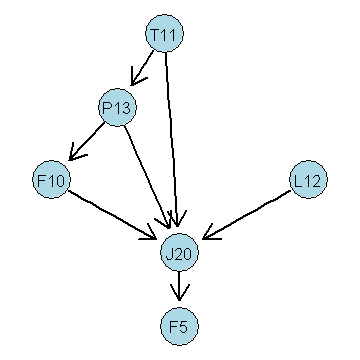

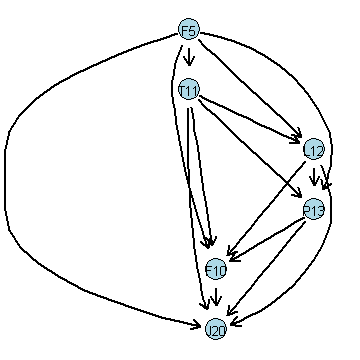

In [75]:
compressor_0 = learn_structure(compressor, "compressor", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.444444444444444"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.363636363636364"


score = BIC, dataset = 3a


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.666666666666667"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.421052631578947"


score = BGE, dataset = 3a


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.666666666666667"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.421052631578947"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  7"
[1] "False Positive         =  6"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.466666666666667"
[1] "Precision              =  0.538461538461538"
[1] "F1 score               =  0.5"


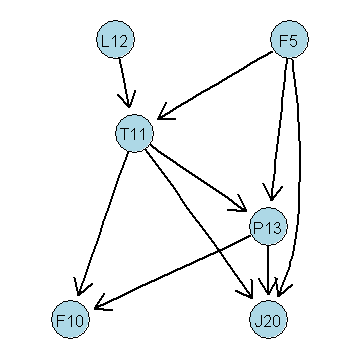

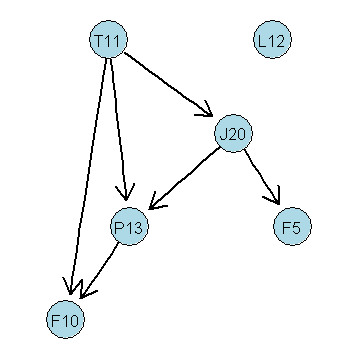

DAG [AIC]:  [F5][L12][T11|F5:L12][P13|F5:T11][F10|T11:P13][J20|F5:T11:P13]
DAG [BIC]:  [T11][L12][J20|T11][F5|J20][P13|T11:J20][F10|T11:P13]
DAG [BGe]:  [T11][L12][J20|T11][F5|J20][P13|T11:J20][F10|T11:P13]
DAG [Loglike]:  [F5][T11|F5][L12|F5:T11][P13|F5:T11:L12][F10|F5:T11:L12:P13][J20|F5:T11:L12:P13:F10]


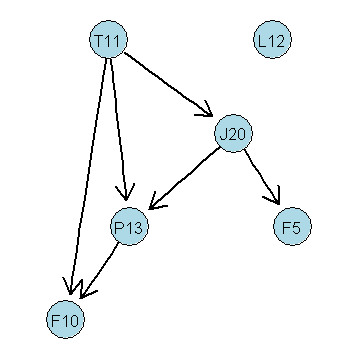

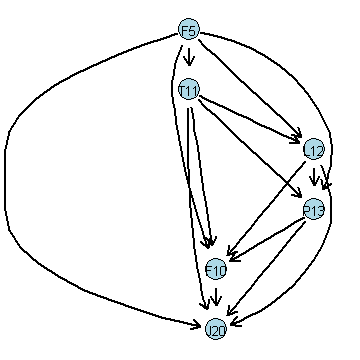

In [76]:
compressor_3a = learn_structure(compressor, "compressor", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  4"
[1] "False Positive         =  9"
[1] "False Negative         =  4"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.307692307692308"
[1] "F1 score               =  0.380952380952381"


score = BIC, dataset = 3d


[1] "True Positive          =  1"
[1] "False Positive         =  12"
[1] "False Negative         =  5"
[1] "Recall (sensitivity)   =  0.166666666666667"
[1] "Precision              =  0.0769230769230769"
[1] "F1 score               =  0.105263157894737"


score = BGE, dataset = 3d


[1] "True Positive          =  3"
[1] "False Positive         =  10"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.5"
[1] "Precision              =  0.230769230769231"
[1] "F1 score               =  0.315789473684211"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  7"
[1] "False Positive         =  6"
[1] "False Negative         =  8"
[1] "Recall (sensitivity)   =  0.466666666666667"
[1] "Precision              =  0.538461538461538"
[1] "F1 score               =  0.5"


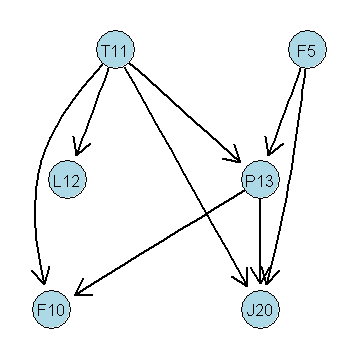

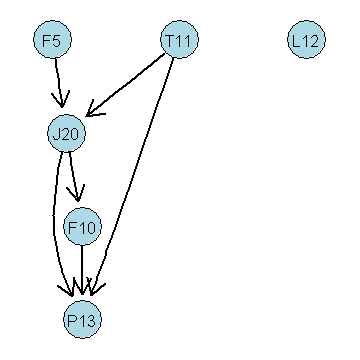

DAG [AIC]:  [F5][T11][L12|T11][P13|F5:T11][F10|T11:P13][J20|F5:T11:P13]
DAG [BIC]:  [F5][T11][L12][J20|F5:T11][F10|J20][P13|T11:F10:J20]
DAG [BGe]:  [T11][F10][L12|T11][P13|T11:F10][J20|T11:P13][F5|J20]
DAG [Loglike]:  [T11][L12|T11][F5|T11:L12][F10|F5:T11:L12][J20|F5:T11:L12:F10][P13|F5:T11:L12:F10:J20]


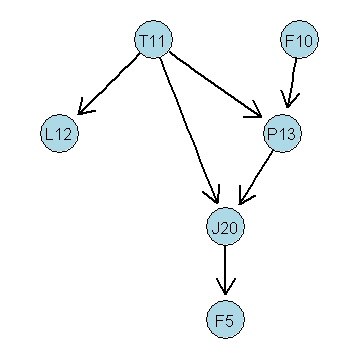

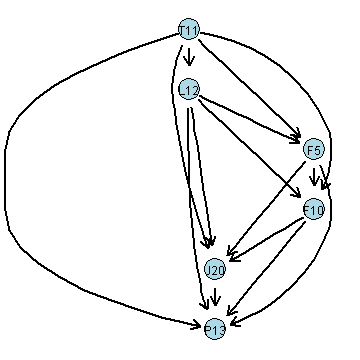

In [77]:
compressor_3d = learn_structure(compressor, "compressor", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on COMPRESSOR structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  7"
[1] "False Positive         =  6"
[1] "False Negative         =  2"
[1] "Recall (sensitivity)   =  0.777777777777778"
[1] "Precision              =  0.538461538461538"
[1] "F1 score               =  0.636363636363636"


score = BIC, dataset = 0


[1] "True Positive          =  5"
[1] "False Positive         =  8"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0.833333333333333"
[1] "Precision              =  0.384615384615385"
[1] "F1 score               =  0.526315789473684"


score = BGE, dataset = 0


[1] "True Positive          =  6"
[1] "False Positive         =  7"
[1] "False Negative         =  1"
[1] "Recall (sensitivity)   =  0.857142857142857"
[1] "Precision              =  0.461538461538462"
[1] "F1 score               =  0.6"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  12"
[1] "False Positive         =  1"
[1] "False Negative         =  3"
[1] "Recall (sensitivity)   =  0.8"
[1] "Precision              =  0.923076923076923"
[1] "F1 score               =  0.857142857142857"


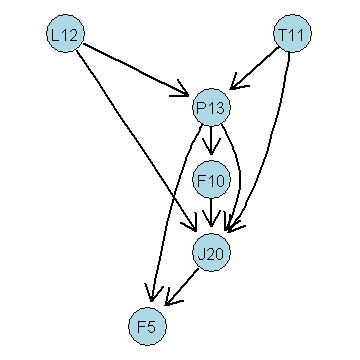

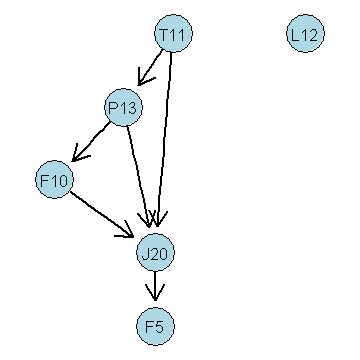

DAG [AIC]:  [T11][L12][P13|T11:L12][F10|P13][J20|T11:L12:P13:F10][F5|P13:J20]
DAG [BIC]:  [T11][L12][P13|T11][F10|P13][J20|T11:P13:F10][F5|J20]
DAG [BGe]:  [T11][L12][P13|T11][F10|P13][J20|T11:L12:P13:F10][F5|J20]
DAG [Loglike]:  [T11][L12|T11][P13|T11:L12][F10|T11:L12:P13][J20|T11:L12:P13:F10][F5|T11:L12:P13:F10:J20]


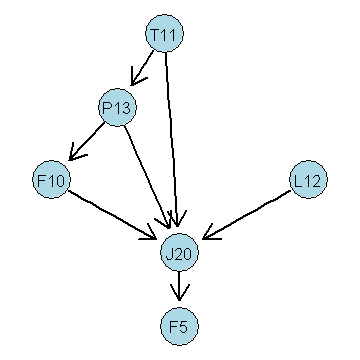

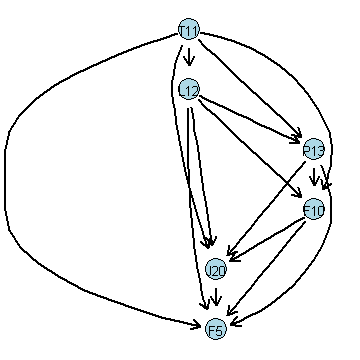

In [78]:
from2  = c("F5", "F5", "F5", "F5", "F5", "J20", "J20", "J20", "J20", "F10", "F10", "F10")
to2 = c("T11", "L12", "P13", "F10", "J20", "T11", "L12", "P13", "F10", "T11", "L12", "P13")
black_compressor = data.frame("from"=from2, "to"=to2)
Compressor_mod = learn_structure(compressor, "compressor", "0", whitelist = NULL, blacklist = black_compressor)

<span style="color:green"><font size="5"><b>[Compressor] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [79]:
rbind(Compressor_mod, Compressor, compressor_0, compressor_3a, compressor_3d)

,aic,bic,bge,loglike
Compressor_mod,0.6363636,0.5263158,0.6,0.8571429
Compressor,0.4545455,0.1111111,0.4210526,0.6428571
compressor_0,0.3636364,0.5263158,0.6,0.5
compressor_3a,0.3636364,0.4210526,0.4210526,0.5
compressor_3d,0.3809524,0.1052632,0.3157895,0.5


<hr>

<hr>

<span style="color:red"><font size="6"><b>8. COMPLETE GRAPH...</b></font></span>

<span style="color:purple"><font size="5"><b>[Complete] Given Structure as per Paper</b></font></span>

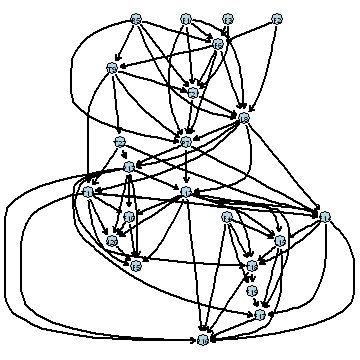

In [80]:
total1 = model2network("[F1][F2][F3][R5][T21|F1:F6:R5:F3:T9][T9|R5:F6][P7|F1:R5:F6:L8:T9:T21][L8|F1:F2:R5:F6:T21][F6|F1:F2:F3:R5][T22|T9][T11|T22:T9:L8][L12|P7:L8:P13][P13|P7:L8:T22][F14|P7:L8:L12:T22:T11][F4][L15|F14:F4:T11:L12][P16|T11:L12:P13:F14:F4:L15:F17:T18][F17|L12:P13:F14:L15:F19][T18|L12:P13:F14:L15:F4][F19|F4:T18][F10|L12:P13:T11][J20|F10:L12:P13:T11][F5|J20:F10:L12:P13:T11]")
plot_graph(total1)

<span style="color:purple"><font size="5"><b>[Complete] Obtained Structure by combining above subparts</b></font></span>

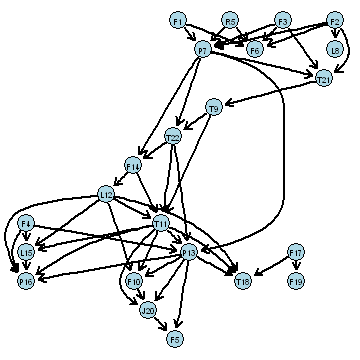

In [81]:
total2 = model2network("[F1][F2][F3][R5][F4][F17][F6|F1:F2:F3:R5][P7|F1:F2:F3:R5][L8|F2][T21|F2:F3:P7][T9|T21][T22|T9:P7][F14|P7:T22][L12|F14][T11|T9:T22:L12:F14][P13|F4:T11:P7:T22][F19|F17][L15|T11:L12:F4][T18|T11:L12:P13:F17][P16|T11:L12:P13:F4:L15][F10|T11:L12:P13][J20|T11:P13:F10][F5|P13:J20]")
plot_graph(total2)

<span style="color:brown"><font size="5"><b>[Complete] Comparing OBTAINED structure with the GIVEN structure</b></font></span>

[1] "True Positive          =  33"
[1] "False Positive         =  40"
[1] "False Negative         =  14"
[1] "Recall (sensitivity)   =  0.702127659574468"
[1] "Precision              =  0.452054794520548"
[1] "F1 score               =  0.55"


True Positive   : BLACK arcs
False Positive  : BLUE arcs
False Negaitive : RED arcs


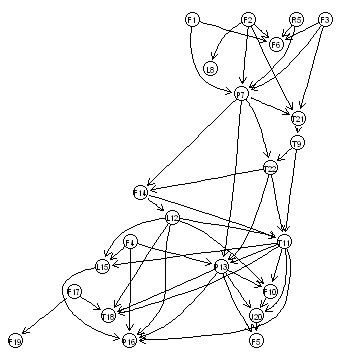

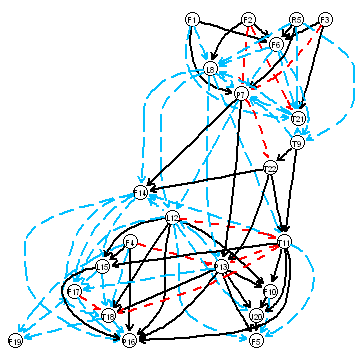

In [82]:
garbage = compare_models(total1, total2)
compare_graph(total2, total1)

In [83]:
Combined = list("aic" = garbage, "bic" = NULL, "bge" = NULL, "loglike" = NULL)

### [Complete] Fitting both into linear gaussian model.

In [84]:
gaussian_total1 <- gaussian(total1, read_data("", "0"))
gaussian_total2 <- gaussian(total2, read_data("", "0"))

[1] "[F1][F2][F3][F4][R5][F6|F1:F2:F3:R5][T9|F6:R5][T21|F1:F3:F6:R5:T9][T22|T9][L8|F1:F2:F6:R5:T21][P7|F1:F6:L8:R5:T21:T9][T11|L8:T22:T9][P13|L8:P7:T22][L12|L8:P13:P7][F10|L12:P13:T11][F14|L12:L8:P7:T11:T22][J20|F10:L12:P13:T11][L15|F14:F4:L12:T11][F5|F10:J20:L12:P13:T11][T18|F14:F4:L12:L15:P13][F19|F4:T18][F17|F14:F19:L12:L15:P13][P16|F14:F17:F4:L12:L15:P13:T11:T18]"
[1] "[F1][F17][F2][F3][F4][R5][F19|F17][F6|F1:F2:F3:R5][L8|F2][P7|F1:F2:F3:R5][T21|F2:F3:P7][T9|T21][T22|P7:T9][F14|P7:T22][L12|F14][T11|F14:L12:T22:T9][L15|F4:L12:T11][P13|F4:P7:T11:T22][F10|L12:P13:T11][P16|F4:L12:L15:P13:T11][T18|F17:L12:P13:T11][J20|F10:P13:T11][F5|J20:P13]"


<hr>

<span style="color:red"><font size="5"><b> STRUCTURE LEARNING STARTS HERE...</b></font></span>

### [Complete] Learning Bayesian Network structure across 4 datasets using score based methods.

score = AIC, dataset = 1a


[1] "True Positive          =  15"
[1] "False Positive         =  58"
[1] "False Negative         =  60"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.205479452054795"
[1] "F1 score               =  0.202702702702703"


score = BIC, dataset = 1a


[1] "True Positive          =  6"
[1] "False Positive         =  67"
[1] "False Negative         =  32"
[1] "Recall (sensitivity)   =  0.157894736842105"
[1] "Precision              =  0.0821917808219178"
[1] "F1 score               =  0.108108108108108"


score = BGE, dataset = 1a


[1] "True Positive          =  5"
[1] "False Positive         =  68"
[1] "False Negative         =  37"
[1] "Recall (sensitivity)   =  0.119047619047619"
[1] "Precision              =  0.0684931506849315"
[1] "F1 score               =  0.0869565217391304"


score = LOGLIKE, dataset = 1a


[1] "True Positive          =  29"
[1] "False Positive         =  44"
[1] "False Negative         =  206"
[1] "Recall (sensitivity)   =  0.123404255319149"
[1] "Precision              =  0.397260273972603"
[1] "F1 score               =  0.188311688311688"


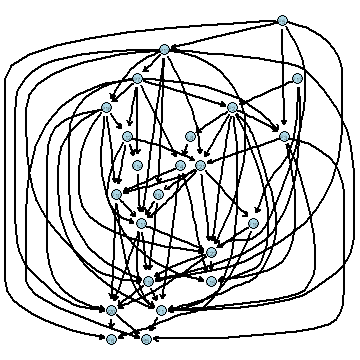

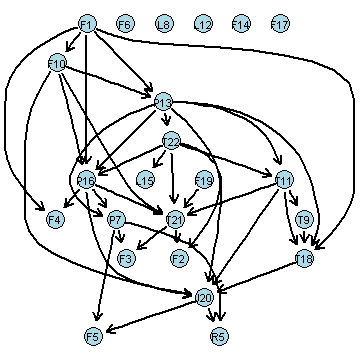

DAG [AIC]:  [F5][F17][P13|F5][P7|P13][F2|P7:F17][P16|P7:P13][F3|F2:F5:P7][L8|F2][L12|P7:P16][F4|P7:L8][F14|P7:L12][T21|F2:F3:L12:P13][T9|P13:T21][F10|F4:L12:P16:T21][F19|F17:T21][T11|T9:F10:P13:F14:P16:T21][T22|F2:F5:T11:P13:P16:F19:T21][L15|F2:F3:F4:L12:T22][T18|F5:P7:T9:T11:P13:F17:T22][F1|F2:F3:F4:F10:T11:P13:P16:T18:F19][J20|F10:T11:P13:P16:T18:T22][F6|F2:F5:J20][R5|F1:F3:P7:J20]
DAG [BIC]:  [F1][F6][L8][L12][F14][F17][F19][F10|F1][P13|F1:F10][T22|P13][T11|P13:T22][L15|T22][P16|F1:F10:P13:T22][F4|F1:P16][P7|P13:P16][T9|T11][T21|F10:T11:P16:F19:T22][F2|P13:T21][F3|P7:T21][T18|F1:T9:T11:P13][J20|F10:T11:P16:T18:T22][F5|P7:J20][R5|P7:J20]
DAG [BGe]:  [F1][F5][L8][F14][F17][F19][P7|F1:F5][R5|F5][F4|F1:P7][P16|F1:P7][F10|F1:P16][T11|P7:F10][T9|T11][P13|F1:P7:T11:P16][T18|F1:T9:T11:P13:R5][T22|T11:P13:P16][L15|T22][J20|F10:T11:P16:T18:T22][T21|F10:T11:P16:F19:T22][F2|P13:T21][F3|P7:T21][F6|J20][L12|F10:T21]
DAG [Loglike]:  [F2][F5|F2][F3|F2:F5][F17|F2:F3:F5][T9|F2:F3:F17][P13|F2:F3:F5:T9

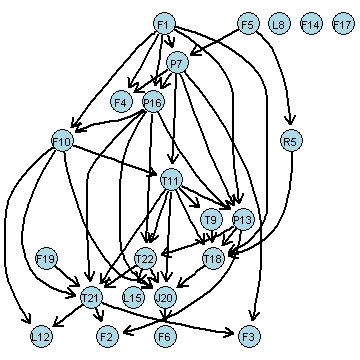

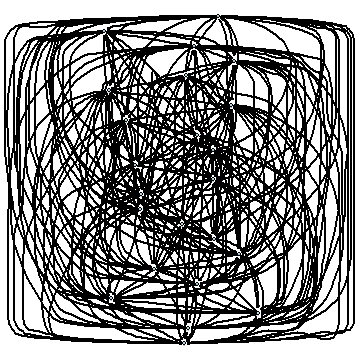

In [86]:
Complete = learn_structure(total1, "", "1a")

score = AIC, dataset = 0


[1] "True Positive          =  13"
[1] "False Positive         =  60"
[1] "False Negative         =  64"
[1] "Recall (sensitivity)   =  0.168831168831169"
[1] "Precision              =  0.178082191780822"
[1] "F1 score               =  0.173333333333333"


score = BIC, dataset = 0


[1] "True Positive          =  8"
[1] "False Positive         =  65"
[1] "False Negative         =  32"
[1] "Recall (sensitivity)   =  0.2"
[1] "Precision              =  0.10958904109589"
[1] "F1 score               =  0.141592920353982"


score = BGE, dataset = 0


[1] "True Positive          =  8"
[1] "False Positive         =  65"
[1] "False Negative         =  34"
[1] "Recall (sensitivity)   =  0.19047619047619"
[1] "Precision              =  0.10958904109589"
[1] "F1 score               =  0.139130434782609"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  32"
[1] "False Positive         =  41"
[1] "False Negative         =  195"
[1] "Recall (sensitivity)   =  0.140969162995595"
[1] "Precision              =  0.438356164383562"
[1] "F1 score               =  0.213333333333333"


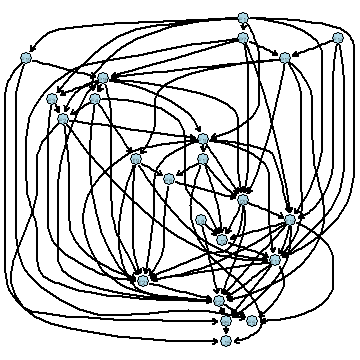

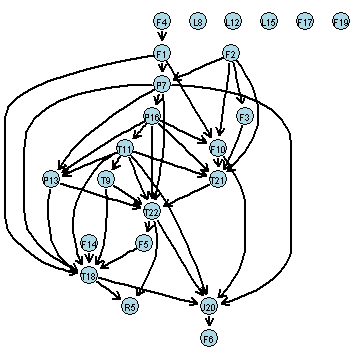

DAG [AIC]:  [F1][L8][F14][P7|F1][F19|F1][P13|P7:F14][P16|P7:P13:F19][F3|F1:P16][F4|F1:P16][F2|F3:F4:P16][T9|F4:P13][F10|F1:F2:P16][F17|F10][F6|T9:F17][J20|F6:P7:F10:P13:P16:F17][T18|F1:P7:F10:F14:J20][L12|F4:L8:F17:T18:J20][T11|F1:F2:T9:F10:L12:P13:F14:T18][T21|F2:F3:F4:F6:T9:F10:T11:P16:T18:J20][T22|P7:L8:T9:F10:T11:P13:P16:T18:J20:T21][F5|T11:T18:F19:T22][R5|T11:T18:F19:T22][L15|F2:F17:R5]
DAG [BIC]:  [F2][F4][L8][L12][F14][L15][F17][F19][F1|F4][F3|F2][P7|F1:F2][P16|P7][F10|F1:F2:P16][T11|P16][T9|T11][P13|P7:T11:P16][T21|F2:F3:F10:T11:P16][T22|P7:T9:T11:P13:P16:T21][F5|T22][T18|F1:F5:P7:T9:T11:P13:F14][J20|P7:F10:T11:T18:T22][R5|T18:T22][F6|J20]
DAG [BGe]:  [F2][F4][F6][L8][T9][L12][F14][L15][F17][F19][F1|F4][F3|F2][J20|F6][F10|F1:F2][P7|F1:F2:F4:F10:J20][T18|P7:L12:F14:J20][F5|T18][P16|F5:P7:F10][R5|F5][T11|F1:F2:P7:T9:P16:T18][T21|F2:F3:F10:T11:P16][T22|F5:P7:T9:T11:P16:T18:J20:T21][P13|P7:F14:P16:T22]
DAG [Loglike]:  [F1][L8|F1][F14|L8][P7|F1:L8:F14][T18|F1:P7:L8:F14][F4|F1:P7:L8:

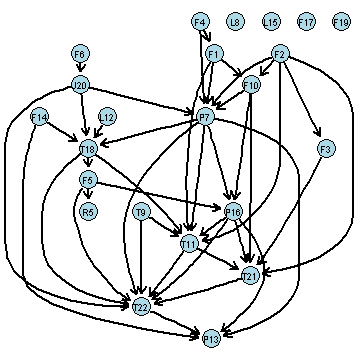

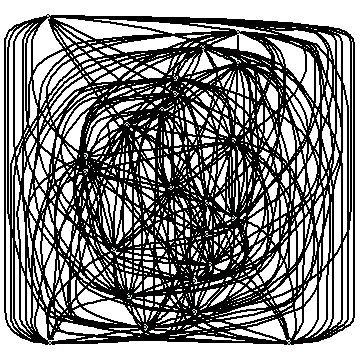

In [87]:
score0 = learn_structure(total1, "", "0")

score = AIC, dataset = 3a


[1] "True Positive          =  13"
[1] "False Positive         =  60"
[1] "False Negative         =  67"
[1] "Recall (sensitivity)   =  0.1625"
[1] "Precision              =  0.178082191780822"
[1] "F1 score               =  0.169934640522876"


score = BIC, dataset = 3a


[1] "True Positive          =  7"
[1] "False Positive         =  66"
[1] "False Negative         =  33"
[1] "Recall (sensitivity)   =  0.175"
[1] "Precision              =  0.0958904109589041"
[1] "F1 score               =  0.123893805309735"


score = BGE, dataset = 3a


[1] "True Positive          =  8"
[1] "False Positive         =  65"
[1] "False Negative         =  41"
[1] "Recall (sensitivity)   =  0.163265306122449"
[1] "Precision              =  0.10958904109589"
[1] "F1 score               =  0.131147540983607"


score = LOGLIKE, dataset = 3a


[1] "True Positive          =  35"
[1] "False Positive         =  38"
[1] "False Negative         =  194"
[1] "Recall (sensitivity)   =  0.152838427947598"
[1] "Precision              =  0.479452054794521"
[1] "F1 score               =  0.231788079470199"


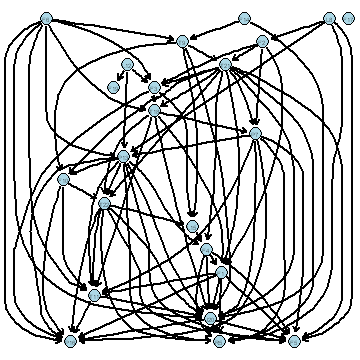

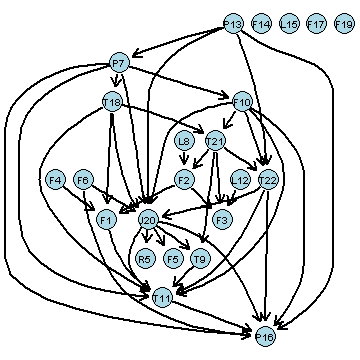

DAG [AIC]:  [F6][L8][L12][F14][F17][F2|L8][T9|F6:F14][F19|L12][T21|F2:T9][F3|F2:F6:L12:T21][T18|F3:F6:T21][P7|F2:T18:T21][P13|F6:P7:L8:L12][F10|T9:P13:T21][T22|F10:P13:T18:T21][L15|F3:T9:T22][F4|P13:L15:T21][F1|F2:F4:T18:T21][T11|F1:F6:P7:F10:P13:T18:T22][J20|F1:F4:F6:P7:T9:T11:P13:F14:T18:T21:T22][F5|F1:F4:P7:L8:P13:J20:T21:T22][P16|F1:F3:F6:P7:F10:T11:P13:J20:T22][R5|F1:F4:P7:L8:P13:J20:T21:T22]
DAG [BIC]:  [F4][F6][L8][L12][P13][F14][L15][F17][F19][P7|P13][F10|P7][T18|P7][T21|F10:T18][F2|L8:T21][T22|F10:P13:T21][F1|F2:F4:T18][F3|F2:L12:T21][J20|F6:P7:F10:P13:T18:T22][F5|J20][T9|J20:T21][R5|J20][T11|F1:P7:T9:F10:T18:J20:T22][P16|F6:P7:F10:T11:P13:J20:T22]
DAG [BGe]:  [F6][L8][L12][F14][L15][F17][T21][F3|L12:T21][F10|T21][F19|L12][J20|F6:F10][F5|J20][T9|F6:J20:T21][T11|F10:J20:T21][P16|F6:F10:T11:T21][R5|F5][F1|P16][T22|F10:T11:L15:P16:T21][F2|F1:F3:L8:T21][F4|F1][P7|F1:F2:F5:P16:J20:T22][P13|F4:F5:P7:P16:J20:T22][T18|F1:T9:F10:T11:P13:J20:T21:T22]
DAG [Loglike]:  [F1][F5|F1][P7|F1:F5

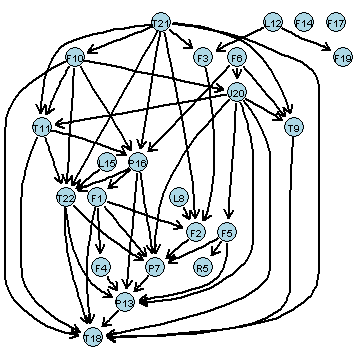

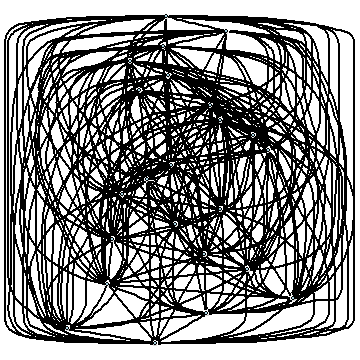

In [88]:
score3a = learn_structure(total1, "", "3a")

score = AIC, dataset = 3d


[1] "True Positive          =  12"
[1] "False Positive         =  61"
[1] "False Negative         =  76"
[1] "Recall (sensitivity)   =  0.136363636363636"
[1] "Precision              =  0.164383561643836"
[1] "F1 score               =  0.149068322981366"


score = BIC, dataset = 3d


[1] "True Positive          =  11"
[1] "False Positive         =  62"
[1] "False Negative         =  30"
[1] "Recall (sensitivity)   =  0.268292682926829"
[1] "Precision              =  0.150684931506849"
[1] "F1 score               =  0.192982456140351"


score = BGE, dataset = 3d


[1] "True Positive          =  8"
[1] "False Positive         =  65"
[1] "False Negative         =  40"
[1] "Recall (sensitivity)   =  0.166666666666667"
[1] "Precision              =  0.10958904109589"
[1] "F1 score               =  0.132231404958678"


score = LOGLIKE, dataset = 3d


[1] "True Positive          =  38"
[1] "False Positive         =  35"
[1] "False Negative         =  195"
[1] "Recall (sensitivity)   =  0.163090128755365"
[1] "Precision              =  0.520547945205479"
[1] "F1 score               =  0.248366013071895"


Warning message in replayPlot(obj):
"zero-length arrow is of indeterminate angle and so skipped"

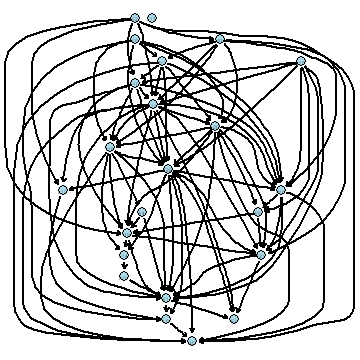

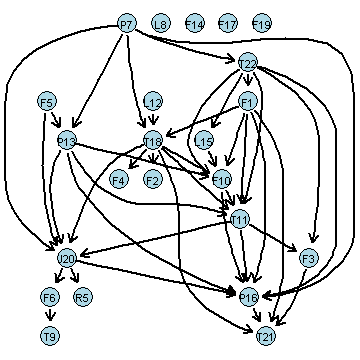

DAG [AIC]:  [F2][F5][L15][F17][P7|F2][P13|F5:P7][F10|F2:P13:L15][T11|F2:P7:F10:P13:L15][J20|F5:P7:T11:P13][T18|F5:P7:F10:T11:J20][F4|T18][T22|F5:F10:T11:P13:L15:T18:J20][L12|F2:T11:T22][P16|F5:P7:F10:T11:P13:L15:J20:T22][F6|L15:P16:J20][T9|F2:F4:F6:F10:T11:T18:J20][F14|T9:T18:T22][T21|F2:F6:T9:T11:L15:P16:J20:T22][F19|F14][F1|F4:T9:F10:T11:L15:P16:T18:F19:J20:T21:T22][F3|F1:T11:T21:T22][L8|F1:F5:L12:T22][R5|P7:L8:T11:P13:P16:T18:J20:T22]
DAG [BIC]:  [F5][P7][L8][L12][F14][F17][F19][P13|F5:P7][T22|P7][F1|T22][L15|T22][T18|F1:P7:L12][F2|T18][F4|T18][F10|F1:P13:L15:T18:T22][T11|F1:F10:P13:T18:T22][F3|T11:T22][J20|F5:P7:T11:P13:T18][F6|J20][P16|F1:P7:F10:T11:P13:J20:T22][R5|J20][T9|F6][T21|F1:F3:P16:T18]
DAG [BGe]:  [F3][F4][F5][L8][F14][L15][F17][F19][F1|F3:F4][R5|F5][T21|F1:F3][P16|T21][P7|F5:P16][P13|F3:F5:P7:P16][F10|F1:P13:L15][J20|F5:P7:P13:L15:P16][F6|J20][T18|F1:F3:P7:F10:L15:P16:T21][F2|F1:T18][T9|F6][L12|T18][T11|F1:F3:F5:T9:F10:T18:J20][T22|F3:P7:F10:T11:P13:L15:P16:T18:J20]
DAG

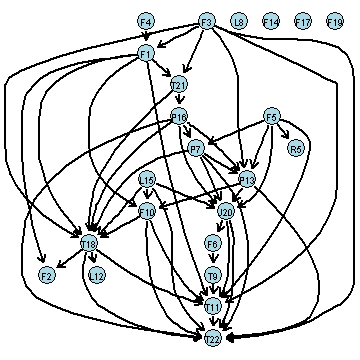

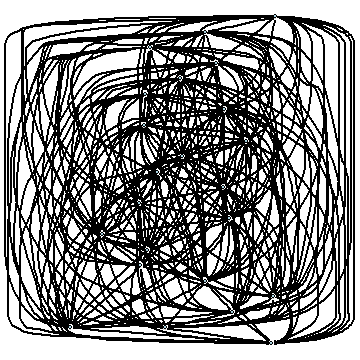

In [89]:
score3d = learn_structure(total1, "", "3d")

<hr>

<span style="color:navy"><font size="5"><b> Putting constraints on COMPLETE structure ...</b></font></span>

score = AIC, dataset = 0


[1] "True Positive          =  22"
[1] "False Positive         =  51"
[1] "False Negative         =  52"
[1] "Recall (sensitivity)   =  0.297297297297297"
[1] "Precision              =  0.301369863013699"
[1] "F1 score               =  0.299319727891156"


score = BIC, dataset = 0


[1] "True Positive          =  10"
[1] "False Positive         =  63"
[1] "False Negative         =  22"
[1] "Recall (sensitivity)   =  0.3125"
[1] "Precision              =  0.136986301369863"
[1] "F1 score               =  0.19047619047619"


score = BGE, dataset = 0


[1] "True Positive          =  10"
[1] "False Positive         =  63"
[1] "False Negative         =  25"
[1] "Recall (sensitivity)   =  0.285714285714286"
[1] "Precision              =  0.136986301369863"
[1] "F1 score               =  0.185185185185185"


score = LOGLIKE, dataset = 0


[1] "True Positive          =  54"
[1] "False Positive         =  19"
[1] "False Negative         =  156"
[1] "Recall (sensitivity)   =  0.257142857142857"
[1] "Precision              =  0.73972602739726"
[1] "F1 score               =  0.381625441696113"


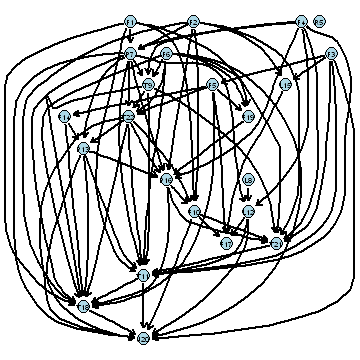

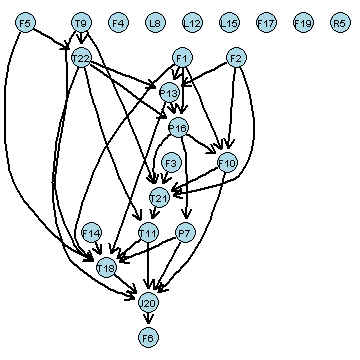

DAG [AIC]:  [F1][F2][F3][F4][F6][L8][R5][F5|F3][P7|F1:F2:F4][L15|F2:F3][T9|F4:F6:P7][L12|F4:P7:L8][F14|F5][F19|F1:F5:F6][T22|F5:F6:P7:T9][P13|P7:F14:T22][P16|F2:F4:P7:P13:F19:T22][F10|F1:F2:P16:T22][F17|F5:F10:L12:L15][T21|F2:F3:F4:F6:T9:F10:P16][T11|F1:F3:F4:F6:P7:T9:L12:P13:T21:T22][T18|F1:F2:F5:F6:P7:T9:T11:P13:F14:P16:T22][J20|F3:F6:P7:F10:T11:L12:P13:T18:T22]
DAG [BIC]:  [F1][F2][F3][F4][F5][L8][T9][L12][F14][L15][F17][F19][R5][T22|F5:T9][P13|F1:F2:T22][P16|F1:P13:T22][P7|P16][F10|F1:F2:P16][T21|F2:F3:T9:F10:P16][T11|T21:T22][T18|F1:F5:P7:T9:T11:P13:F14][J20|P7:F10:T11:T18:T22][F6|J20]
DAG [BGe]:  [F1][F2][F3][F4][L8][T9][L12][F14][L15][F17][F19][R5][F5|R5][T22|F5:T9][P13|F1:F2:T22][P16|F1:P13:T22][P7|P16][F10|F1:F2:P16:T22][T21|F2:F3:T9:F10:P16][T11|P13:T21:T22][T18|F1:F5:P7:T9:T11:P13:F14][J20|P7:F10:T11:T18:T22][F6|J20]
DAG [Loglike]:  [F1][F2][F3][F4][R5][F6|F1:F2:F3:F4:R5][L8|F1:F2:F3:F4:F6:R5][T9|F1:F2:F3:F4:F6:L8:R5][T11|F1:F2:F3:F6:L8:T9:R5][L12|F1:F2:F3:F4:F6:L8:T9:T11:R5

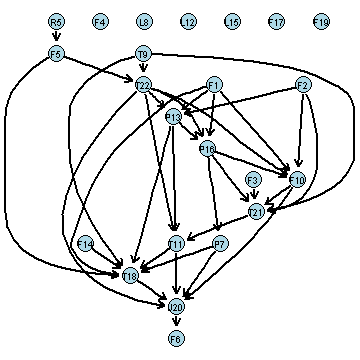

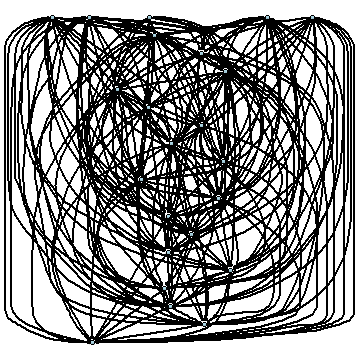

In [90]:
from2 = c("F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7", "T22", "T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19", "F10", "J20", "F5", "F1", "F3", "R5", "F6", "T21", "T9", "L8", "P7", "T22", "T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19", "F10", "J20", "F5", "F1", "F2", "R5", "F6", "T21", "T9", "L8", "P7", "T22", "T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19", "F10", "J20", "F5", "F1", "F2", "F3", "F6", "T21", "T9", "L8", "P7", "T22", "T11", "L12", "P13", "F14", "F4", "L15", "P16", "F17", "T18", "F19", "F10", "J20", "F5", "F1", "F2", "F3", "R5", "F6", "T21", "T9", "L8", "P7", "T22", "T11", "L12", "P13", "F14", "L15", "P16", "F17", "T18", "F19", "F10", "J20", "F5", "F6", "F6", "F6", "F6", "P7", "L8", "T9", "T21", "T22", "T22", "T22", "T22", "T22", "T22", "T11", "T11", "T11", "T11", "L12", "L12", "L12", "L12", "P13", "P13", "P13", "P13", "F14", "F14", "F14", "F14", "L15", "L15", "L15", "L15", "L15", "P16", "P16", "P16", "P16", "P16", "F17", "F17", "F17", "F17", "F17", "T18", "T18", "T18", "T18", "T18", "F19", "F19", "F19", "F19", "F19", "T11", "L12", "P13", "F14", "F5", "F5", "F5", "F5", "F5", "J20", "J20", "J20", "J20", "F10", "F10", "F10")
to2 = c("F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "F3", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "R5", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "F4", "R5", "F3", "F2", "F1", "F6", "F6", "F6", "F6", "T9", "F6", "P7", "L8", "T9", "T21", "P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22", "P7", "L8", "T9", "T22", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "T11", "L12", "P13", "F14", "F4", "F4", "F4", "F4", "F4", "T11", "L12", "P13", "F10", "J20", "T11", "L12", "P13", "F10", "T11", "L12", "P13")
black_complete = data.frame("from"=from2, "to"=to2)
Complete_mod = learn_structure(total1, "", "0", whitelist = NULL, blacklist = black_complete)

<span style="color:green"><font size="5"><b>[Complete] Comparison of F1 score across various score-based methods and datasets</b></font></span>

In [91]:
rbind(Combined, Complete_mod, Complete, score0, score3a, score3d)

,aic,bic,bge,loglike
Combined,0.55,NULL,NULL,NULL
Complete_mod,0.2993197,0.1904762,0.1851852,0.3816254
Complete,0.2027027,0.1081081,0.08695652,0.1883117
score0,0.1733333,0.1415929,0.1391304,0.2133333
score3a,0.1699346,0.1238938,0.1311475,0.2317881
score3d,0.1490683,0.1929825,0.1322314,0.248366


<hr>

<span style="color:orange"><font size="5"><b>[Complete] Comparison of F1 score of individual units and combined structure across various score-based methods</b></font></span>

In [92]:
rbind(Mixer, Mixer_mod, Reactor, Reactor_mod, Condenser, Condenser_mod, Separator, Separator_mod, Stripper, Stripper_mod, Compressor, Compressor_mod, Complete, Complete_mod, Combined)

,aic,bic,bge,loglike
Mixer,0.5,0,0,0.5714286
Mixer_mod,0,0,0,1
Reactor,0.3428571,0.2,0.2,0.5
Reactor_mod,0.375,0.2142857,0.2142857,0.6923077
Condenser,1,1,1,1
Condenser_mod,1,1,1,1
Separator,0.24,0.1818182,0.1818182,0.5238095
Separator_mod,0.5517241,0.4347826,0.32,0.5909091
Stripper,0.2790698,0.1818182,0.1212121,0.3768116
Stripper_mod,0.3902439,0.2352941,0.2352941,0.6857143


<hr>

<hr>

<hr>